In [2]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from metadata.etfs import etfs_large, etfs_small

warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [3]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl

def calculateRollingSharpeRatio(dfPnl, window = 3, annulaize = 12, rf = 0):
    rolling_mean = (dfPnl.rolling(window=window).mean() - rf) 
    rolling_std = dfPnl.rolling(window=window).std()

    # replace zeros with NaNs
    rolling_std = rolling_std.replace(0, np.nan)

    rolling_sr = rolling_mean / rolling_std * np.sqrt(annulaize)

    return rolling_sr

def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateExpectedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

def calculateVolatility(dfPnl, annualize = 12):
    v = dfPnl.std() * annualize * 100
    return v

def calculateSortino(dfPnl, annualize = 12):
    
    # portfolio downside vol
    downside_rets = dfPnl.copy()
    downside_rets[downside_rets >= 0] = np.nan
    downside_vol = downside_rets[~pd.isna(downside_rets)].std()

    # portfolio sharpe
    sortino_ratio = (dfPnl.mean() / downside_vol) * annualize

    return sortino_ratio

def calculateAvgDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    avg_drawdown = drawdown.mean() * 100

    return avg_drawdown

def calculateMaxDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    max_drawdown = drawdown.min() * 100

    return max_drawdown

In [4]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_funcs = {
    "E[Rt]": calculateExpectedReturn,
    "Volatility": calculateVolatility,
    "Sharpe": calculateSharpeRatio,
    "Sortino": calculateSortino,
    "AvgDD": calculateAvgDD,
    "MaxDD": calculateMaxDD,    
}
# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]

In [5]:
all_pnl = []
all_measures = []
for etf in etfs_large:
    for i, fs in enumerate(fs_methods):
        files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))

        if len(files) != 1:
            raise ValueError(f"Found {len(files)} files for {etf} and {fs}.")

        for f in files:
            dfPred = load_pickle(f)["predictions"]
            # dfPred = np.log(1 + dfPred / 100)
            
            # run backtest
            bt = backtester(dfPred)
            bt.simpleStrategy()

                # extract pnl
            if i == 0:
                dfPnl = dfPred[["true"]].copy()
                dfPnl.columns = [etf]
            dfPnl[fs] = bt.pnl
    
    # save pnl
    melt_dfPnl = dfPnl.reset_index().melt("date")
    melt_dfPnl["etf"] = etf
    all_pnl.append(melt_dfPnl)

    # calculate measures
    measures = []
    for tag, performance_measure in metric_funcs.items():
        measure = performance_measure(dfPnl)
        measures.append(pd.DataFrame(measure, columns=[tag]))

    measures_df = pd.concat(measures, axis=1)
    melt_measures_df = measures_df.reset_index().melt("index")
    melt_measures_df["etf"] = etf
    all_measures.append(melt_measures_df)

all_measures_df = pd.concat(all_measures)
all_pnl_df = pd.concat(all_pnl)

### Plot Correlation Matrices

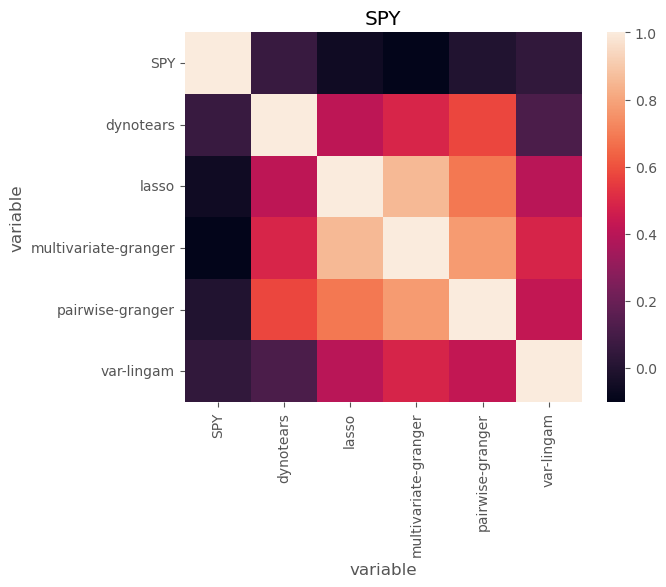

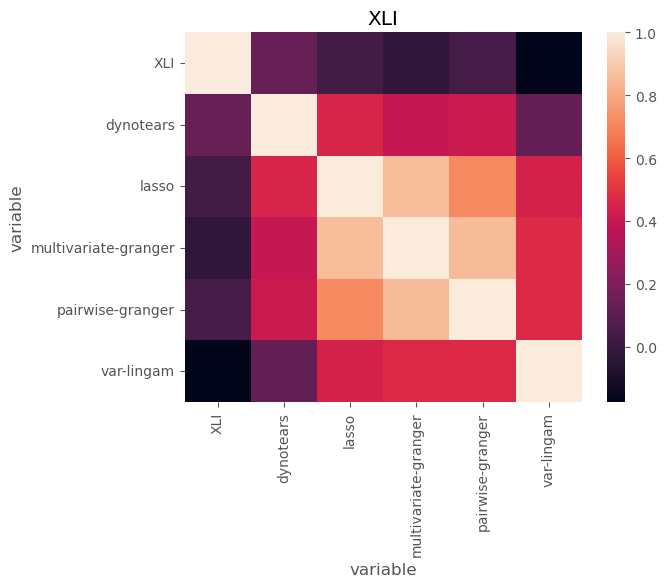

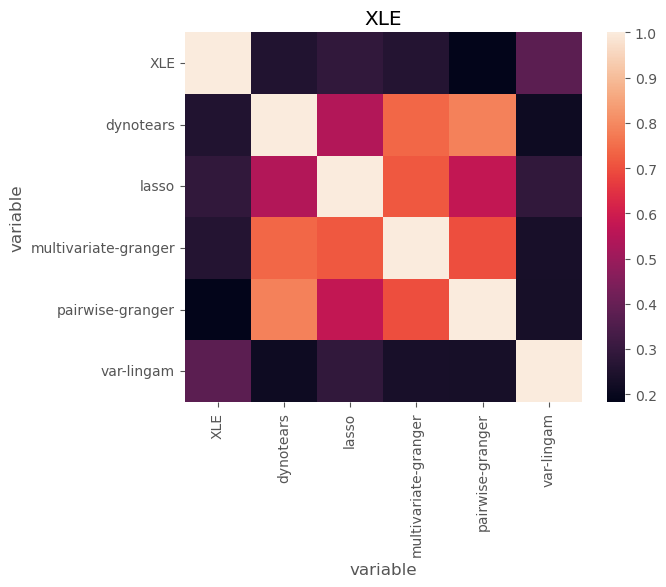

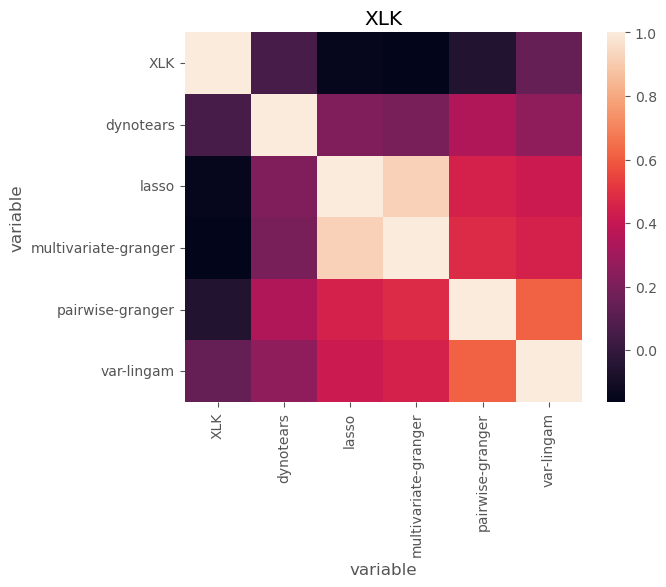

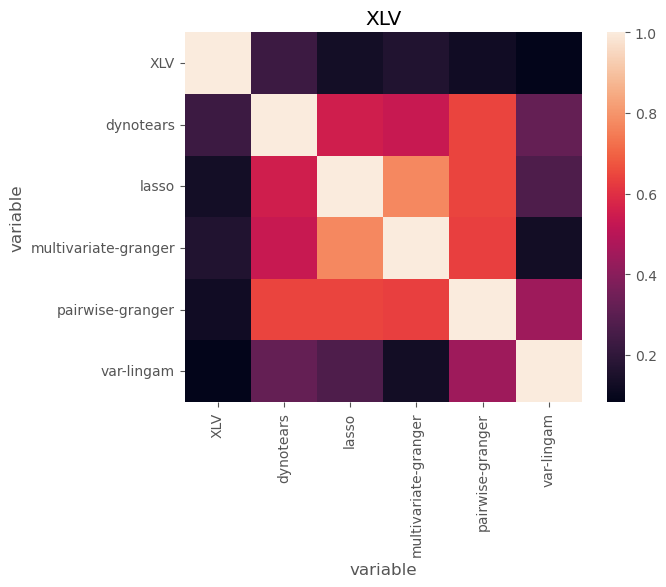

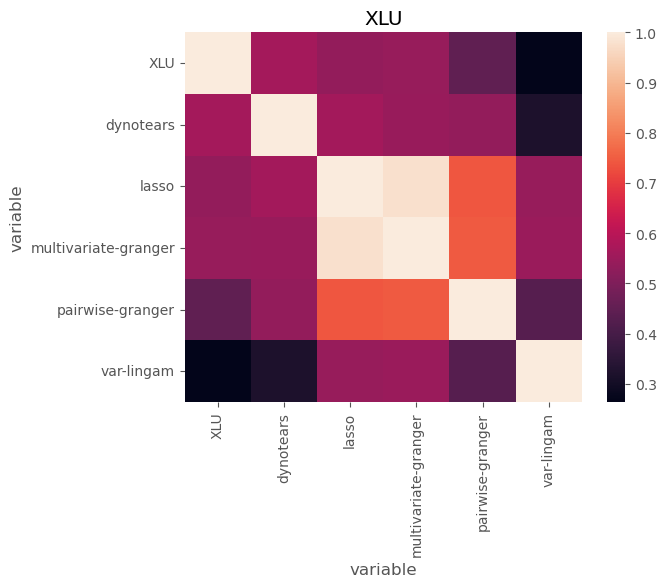

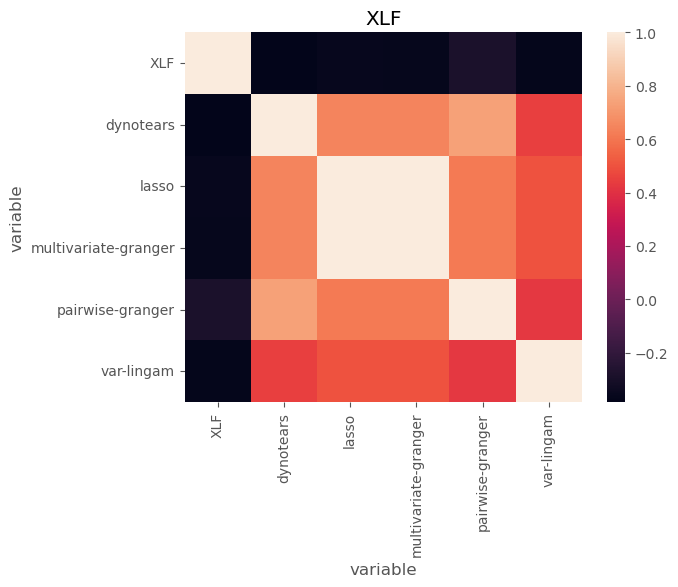

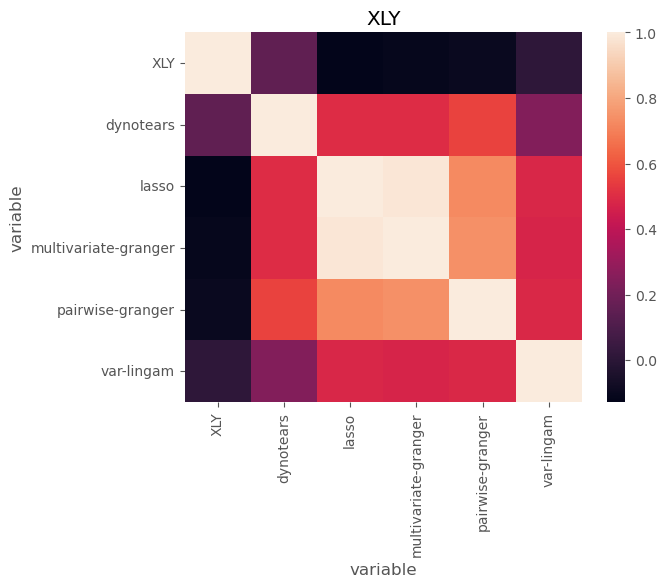

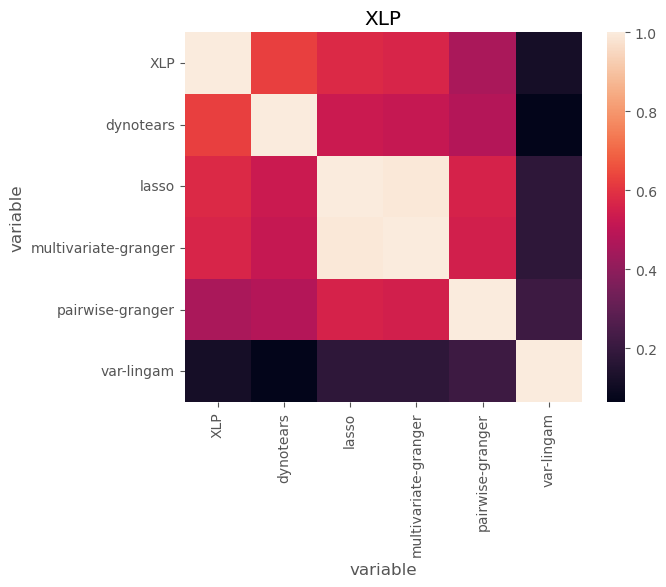

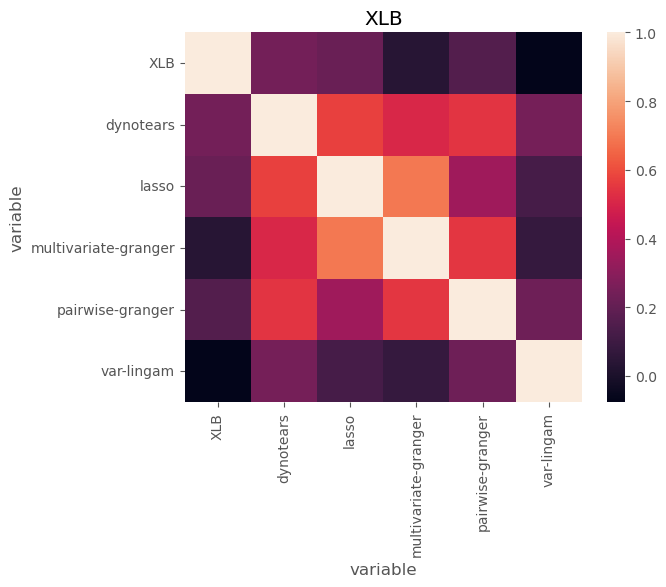

In [6]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    corr = tmp_dfPnl.corr()

    sns.heatmap(corr)
    plt.title(target)
    plt.show()

### Boxplot Portfolio Metrics

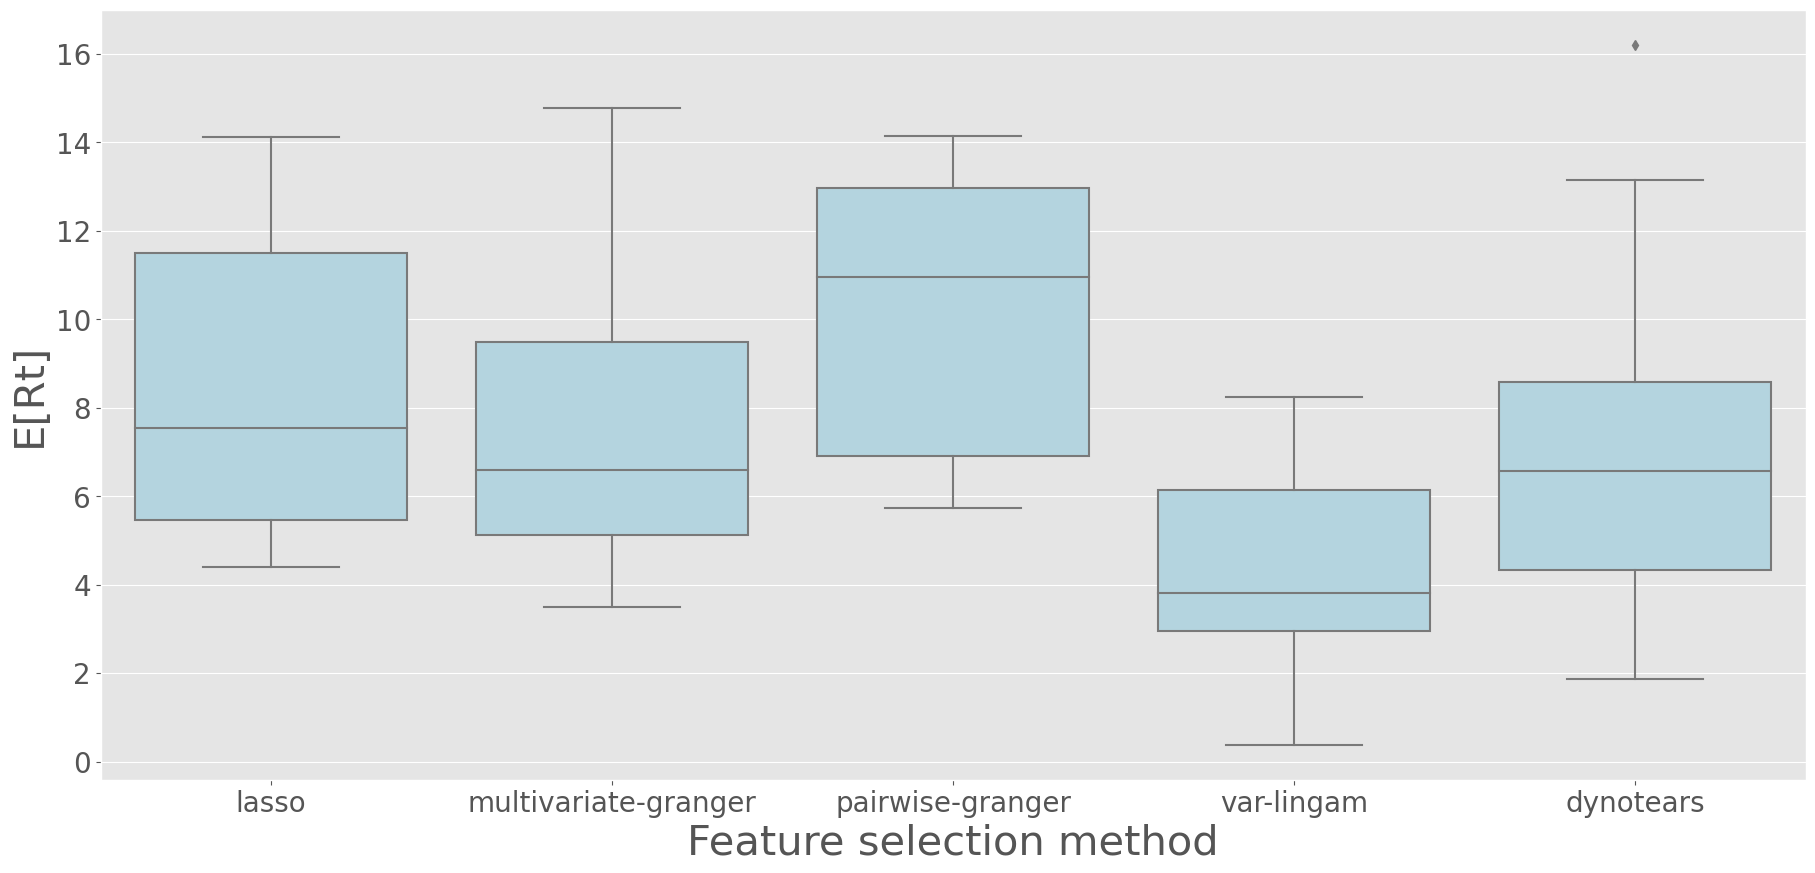

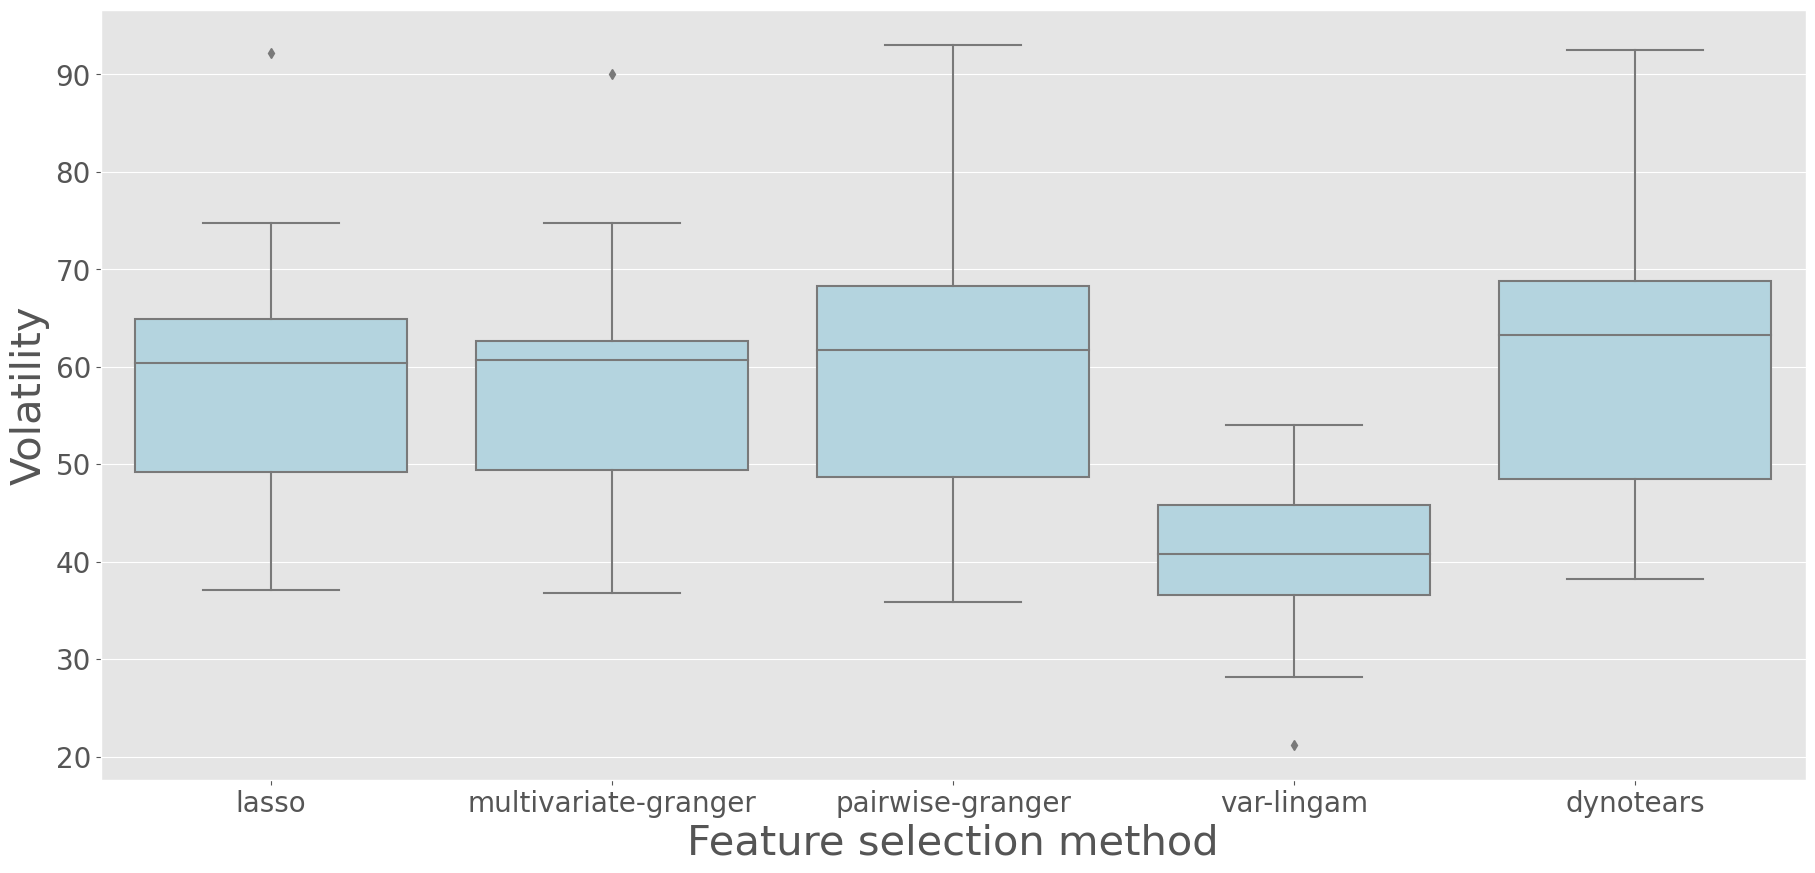

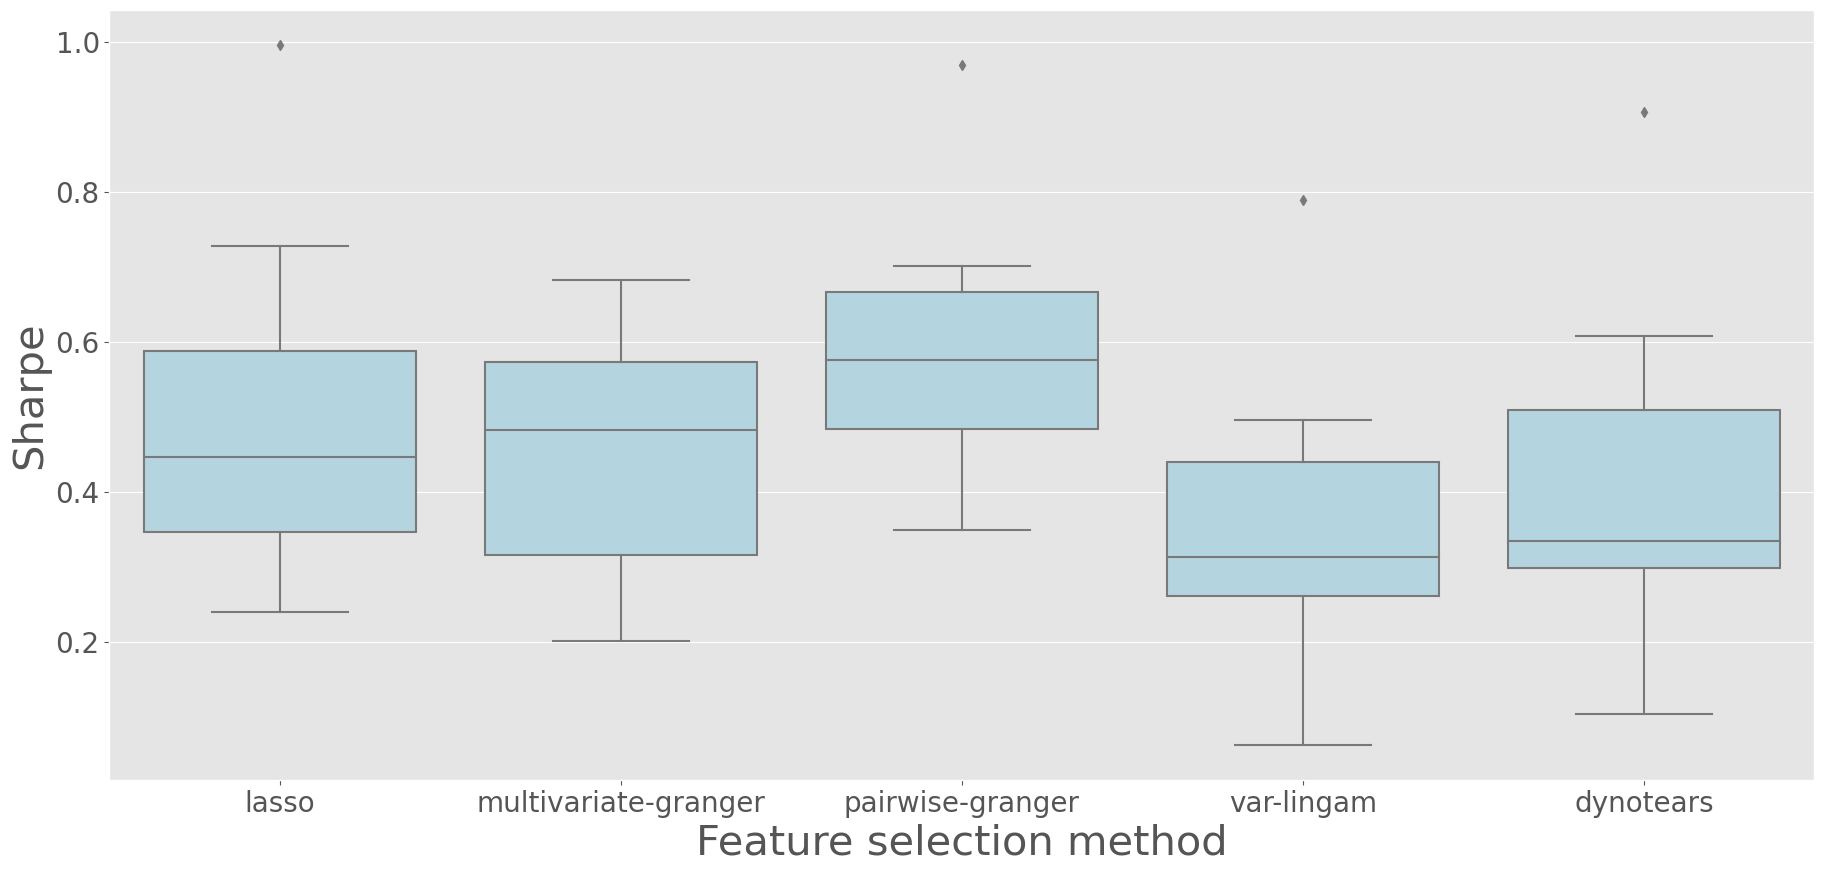

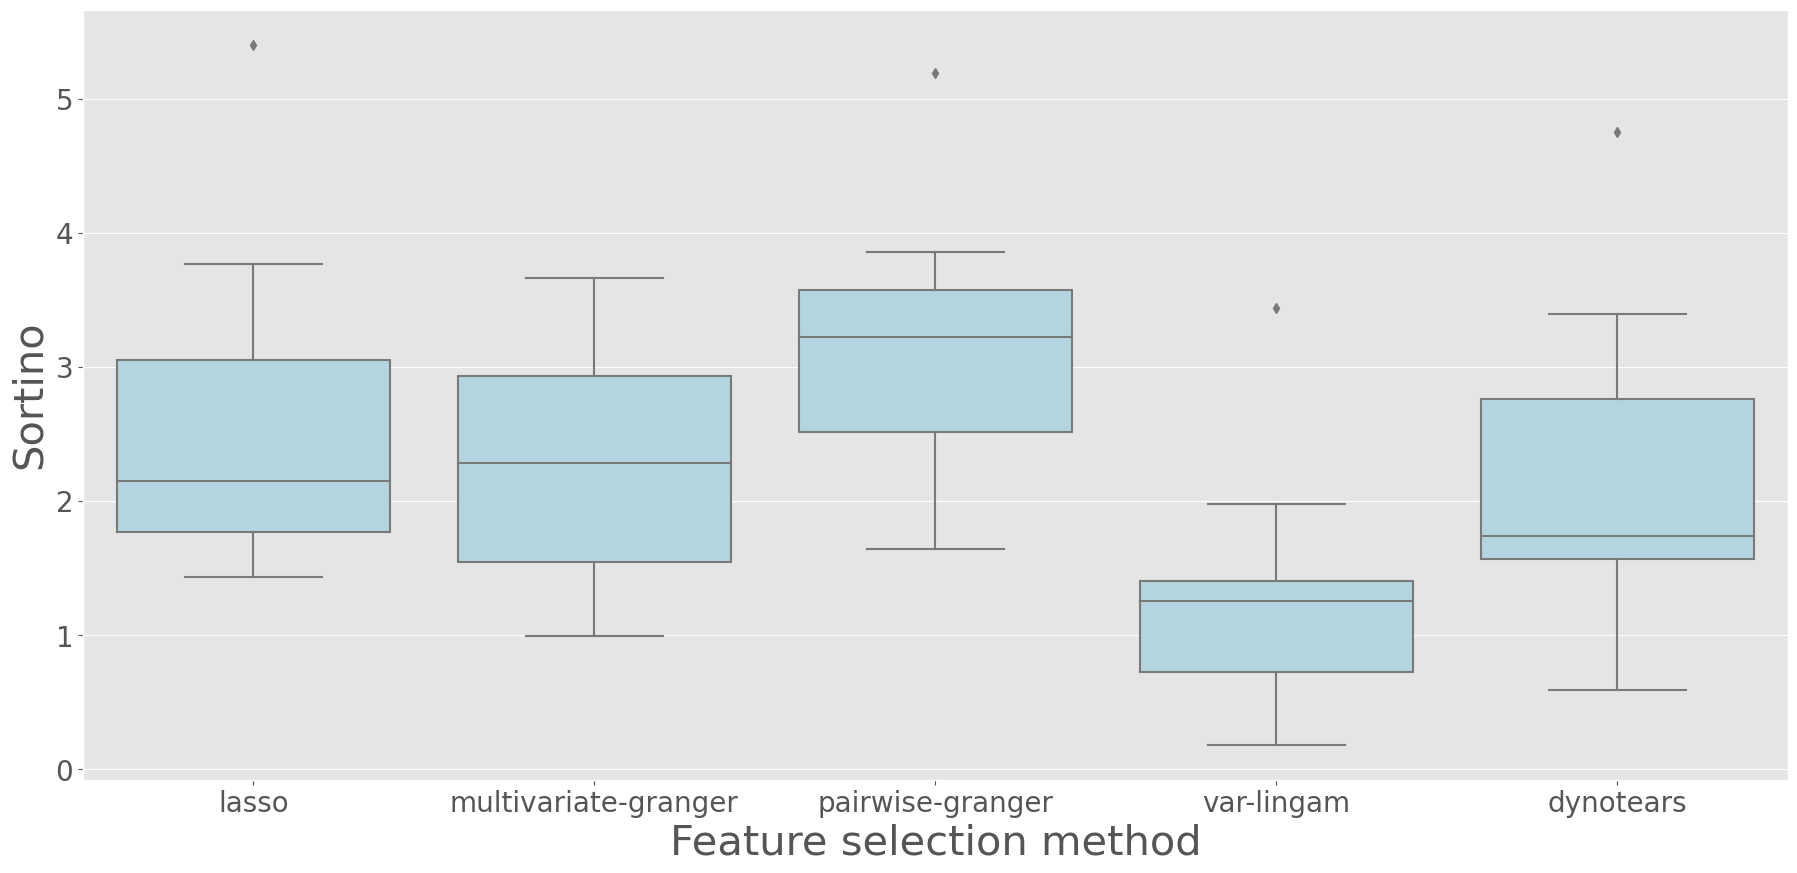

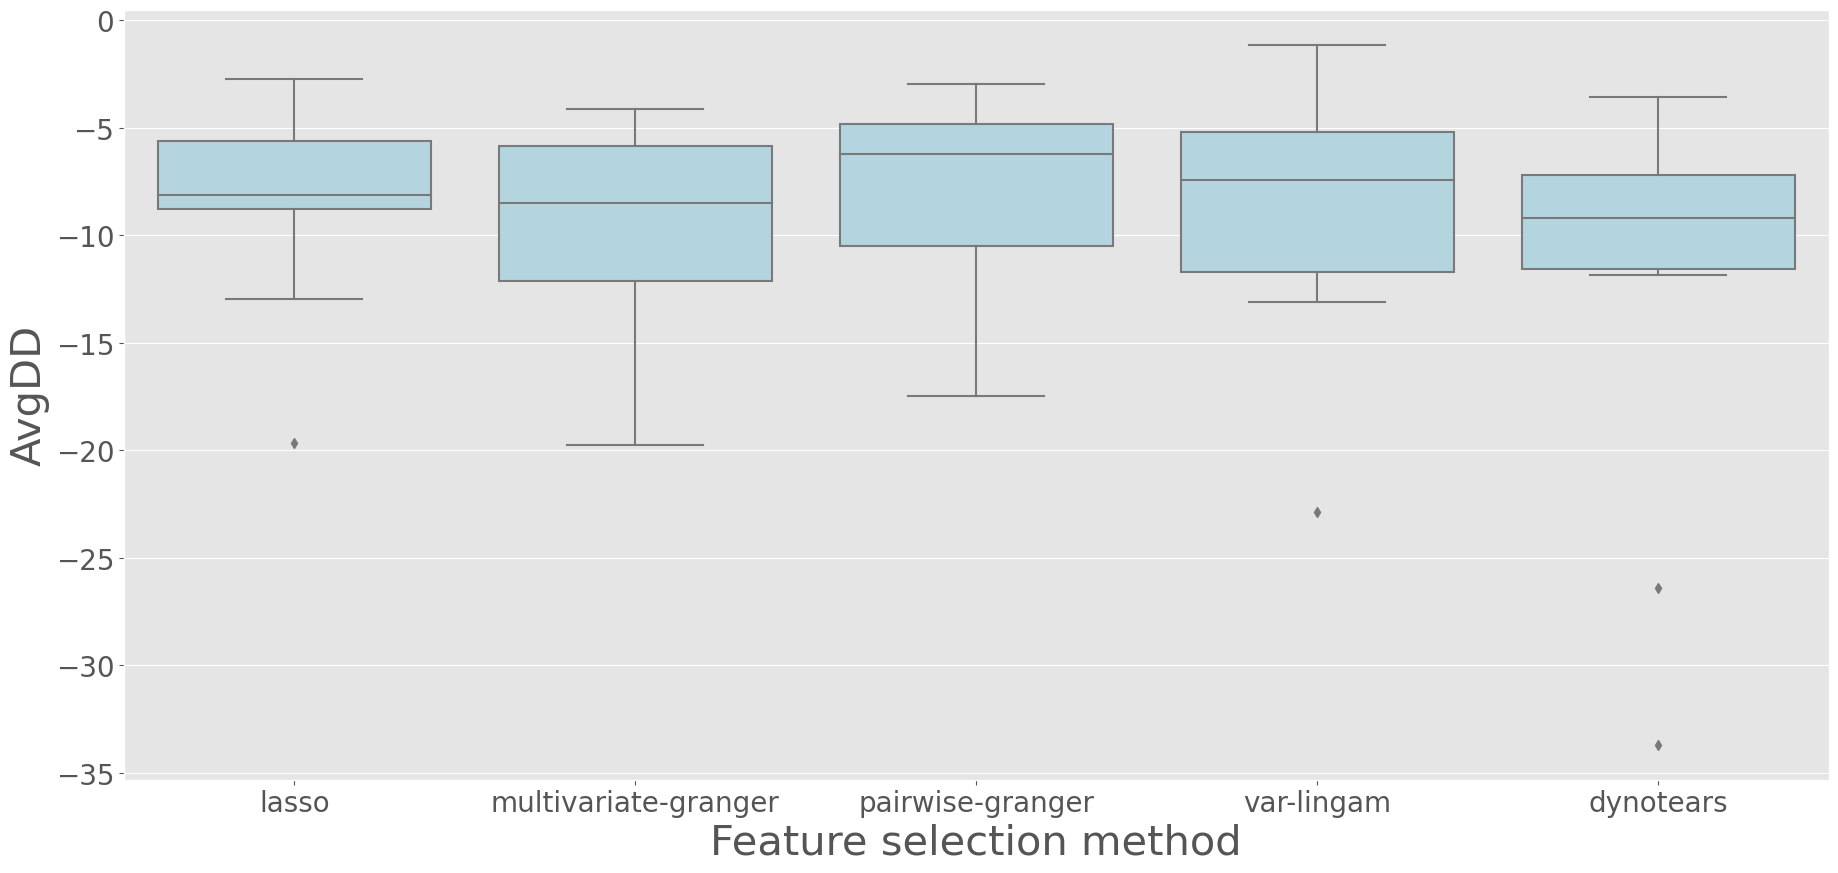

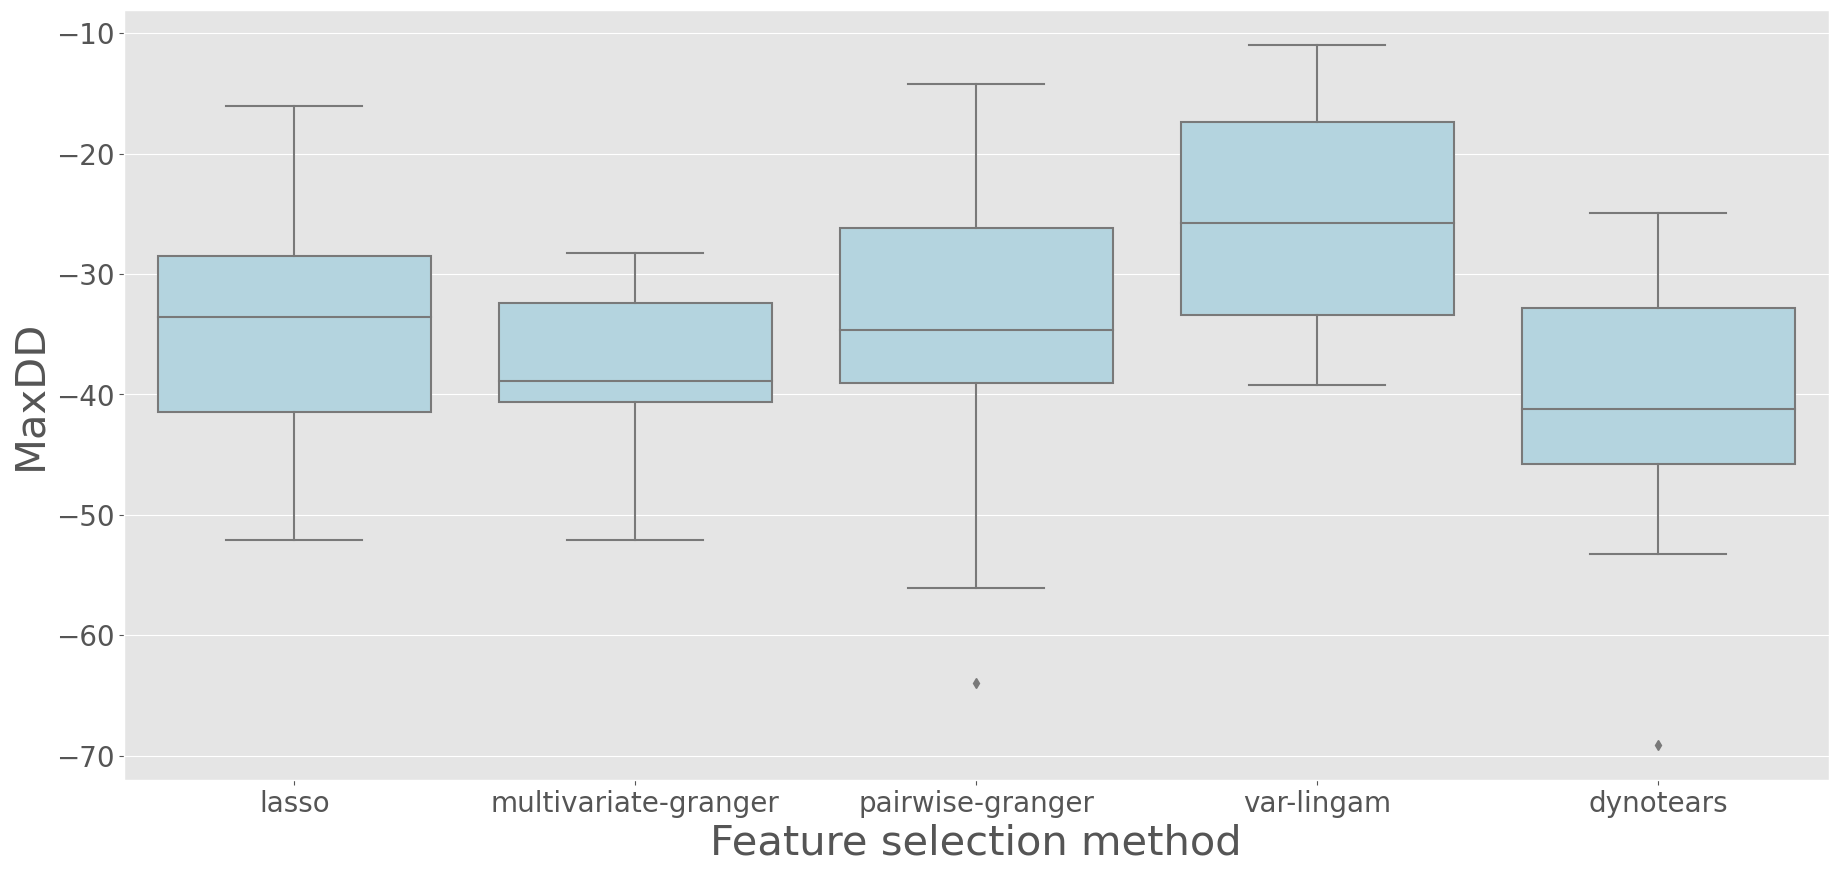

In [7]:
for measure in all_measures_df["variable"].unique():
    boxplot_df = all_measures_df.loc[(all_measures_df["variable"] == measure)&
                                     (~all_measures_df["index"].isin(etfs_large))].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="index", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(measure, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)

### Plot Cumulative Returns

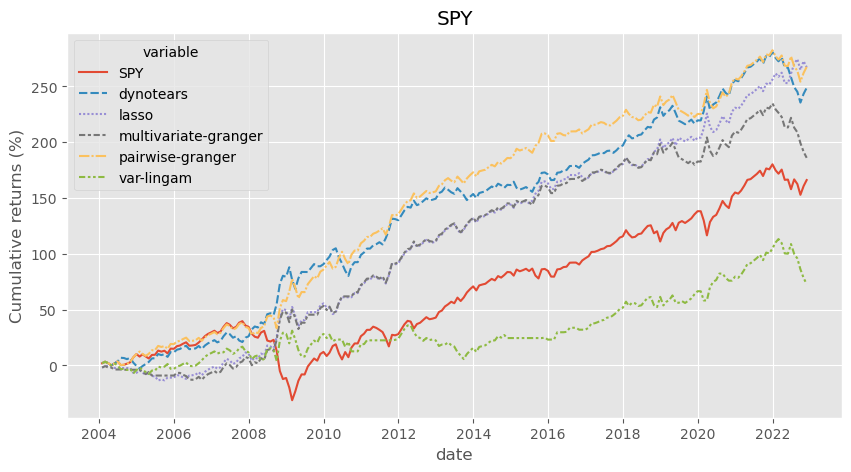

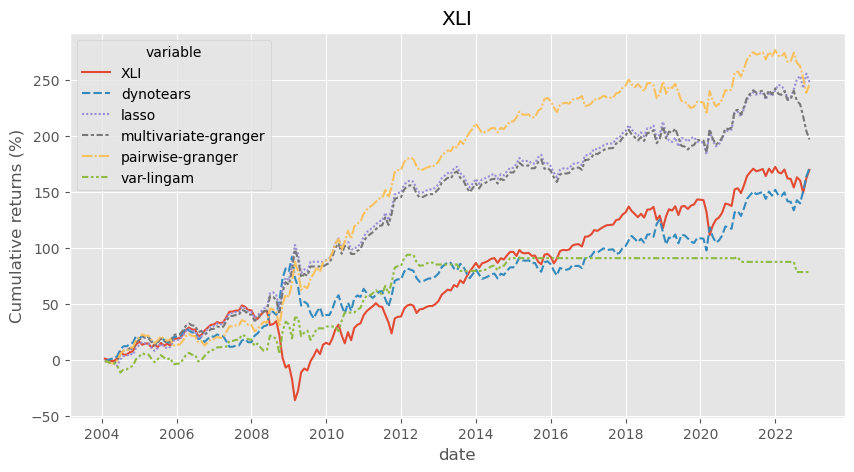

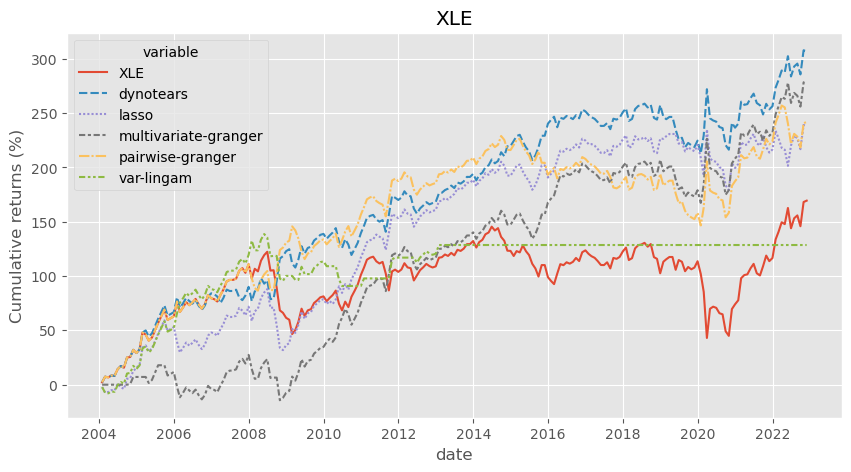

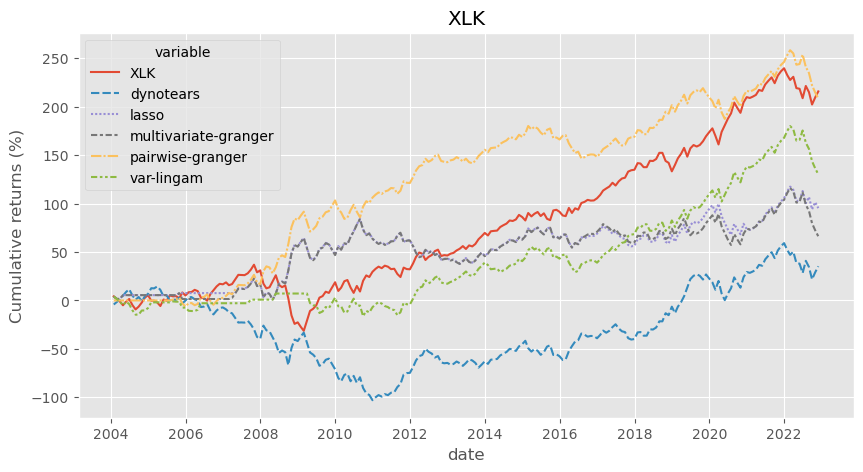

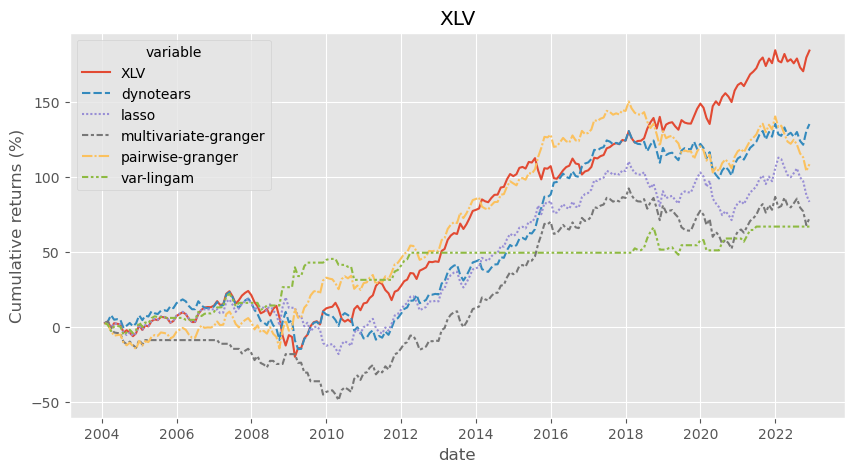

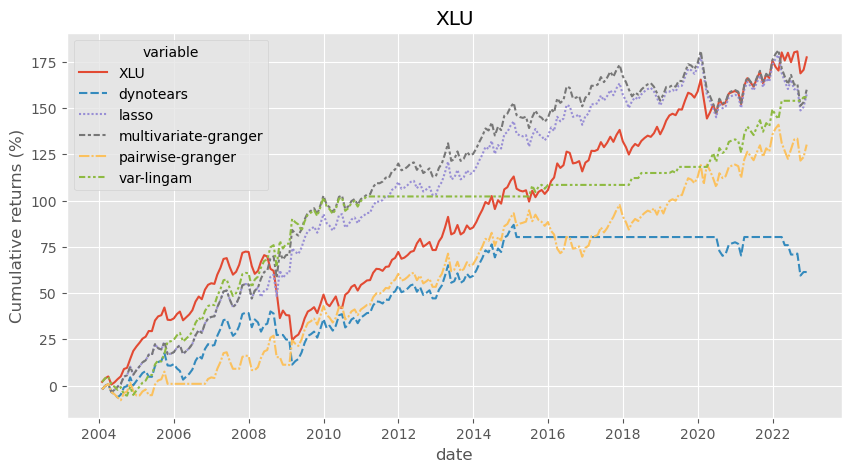

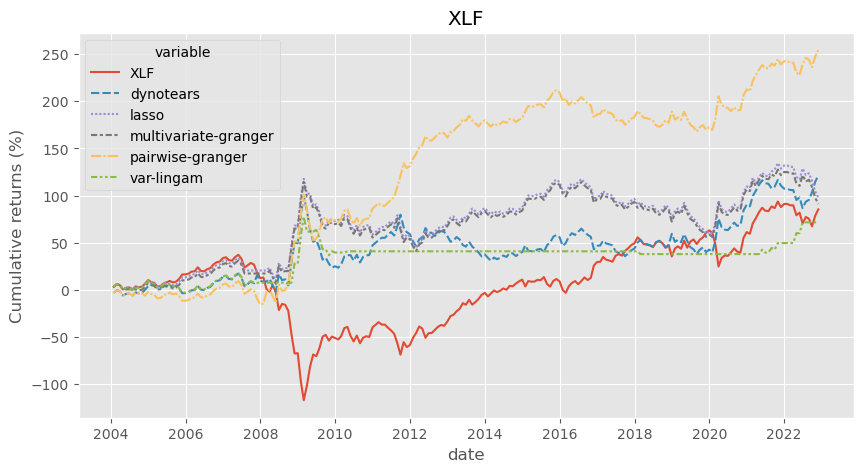

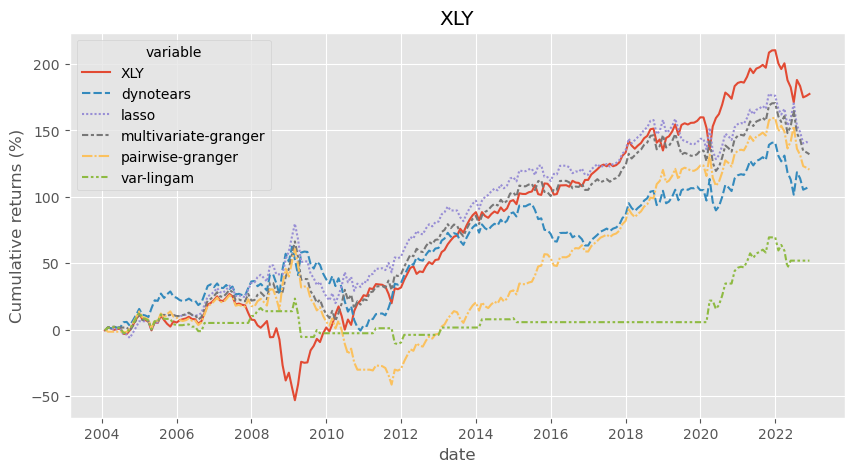

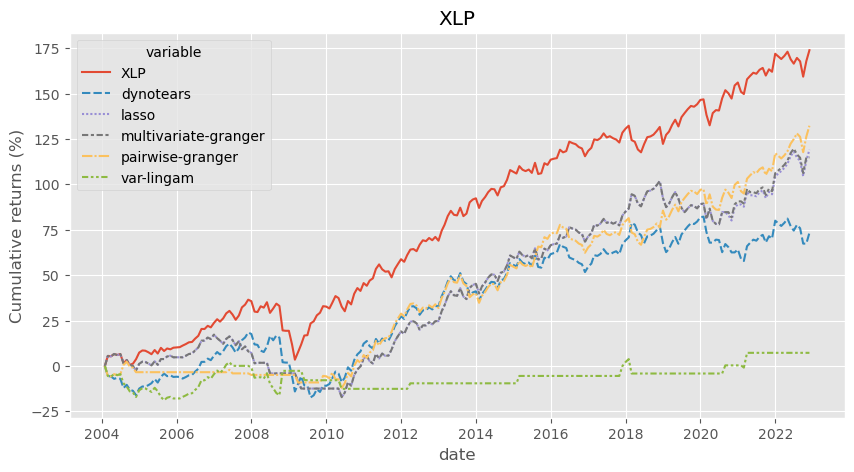

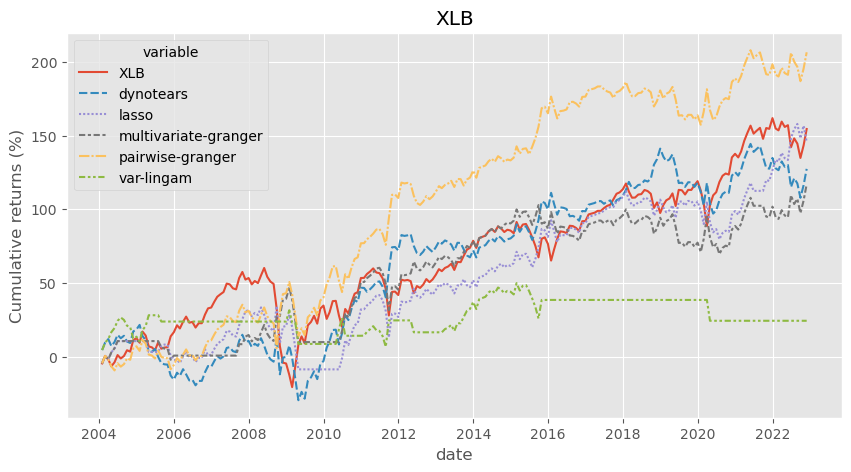

In [19]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    sns.lineplot(data = tmp_dfPnl.cumsum() * 100, ax = ax)
    ax.set_ylabel("Cumulative returns (%)")
    ax.set_title(target)

    # export figure
    fig.savefig(f"{target}_cum_ret.png")

### Plot Rolling Sharpe Ratios

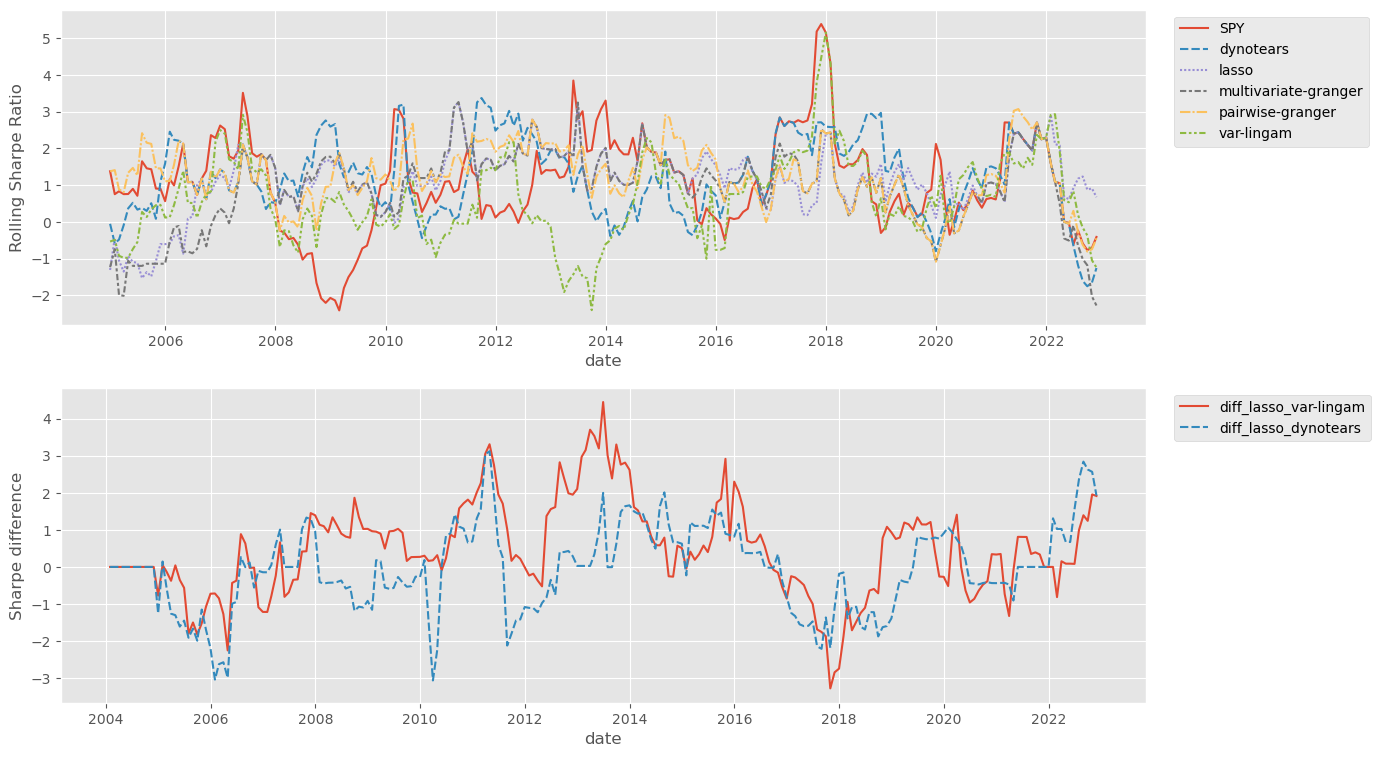

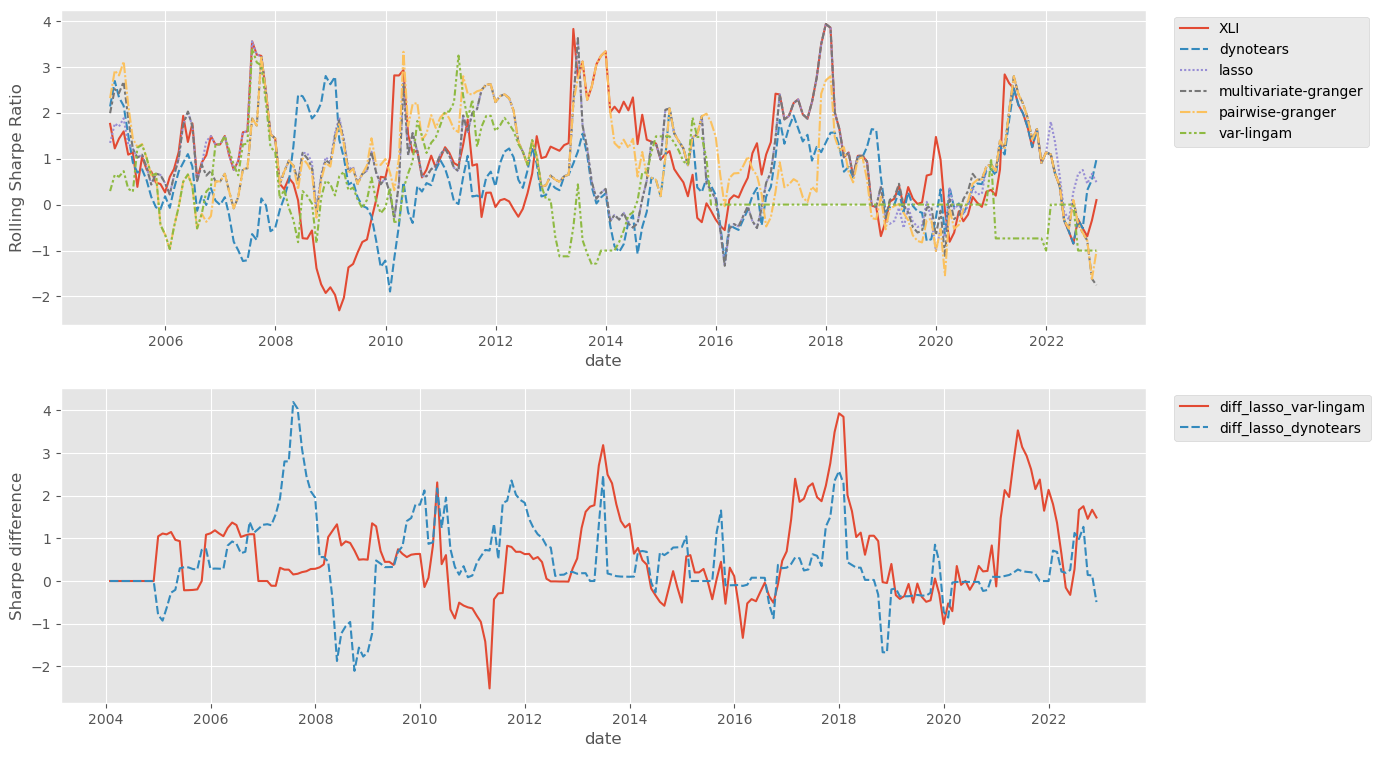

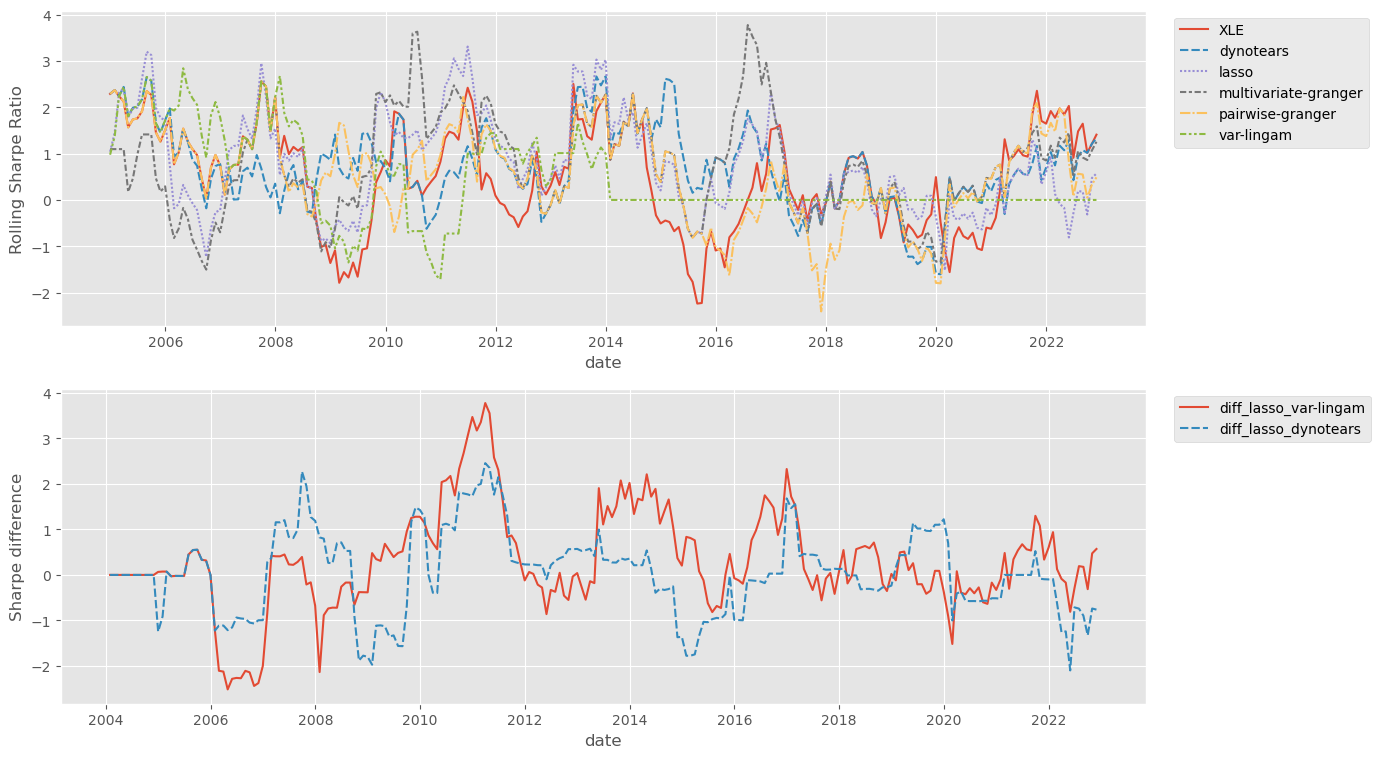

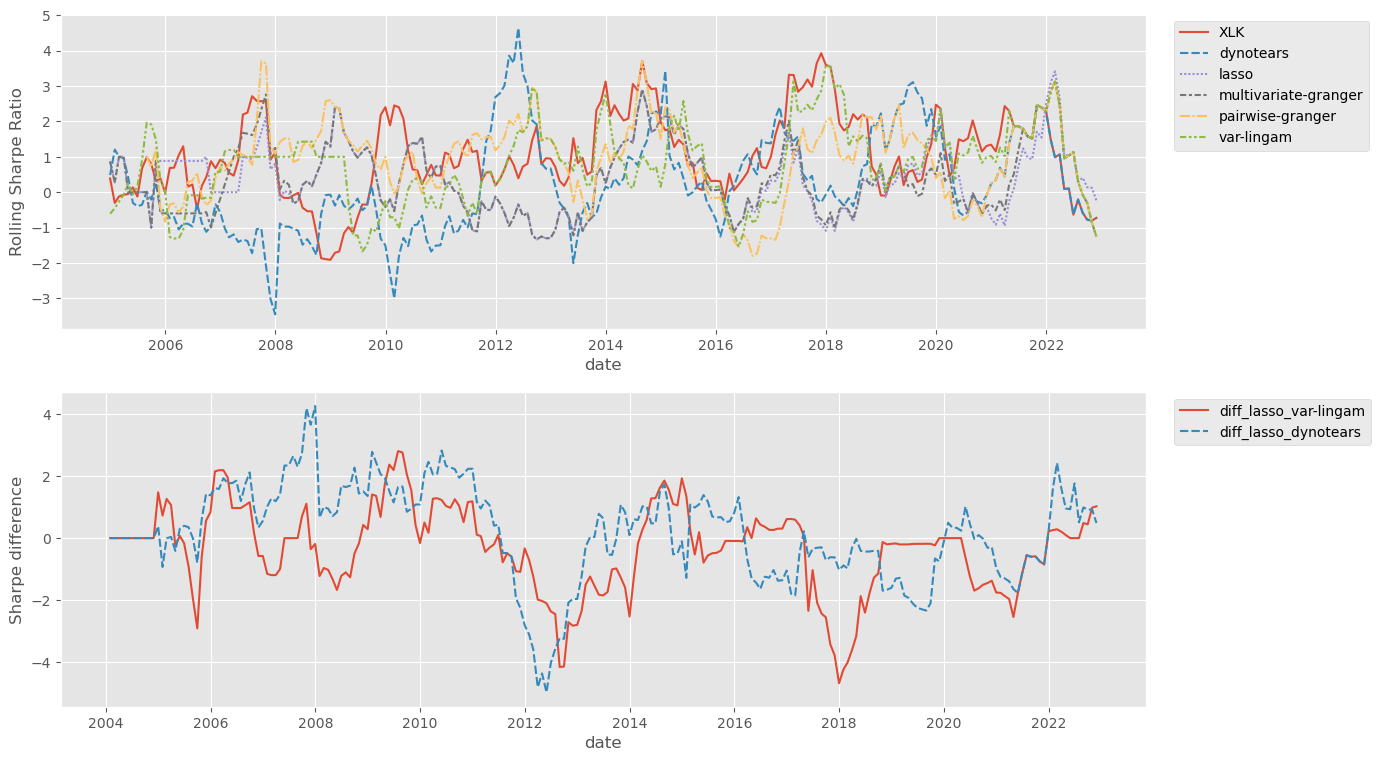

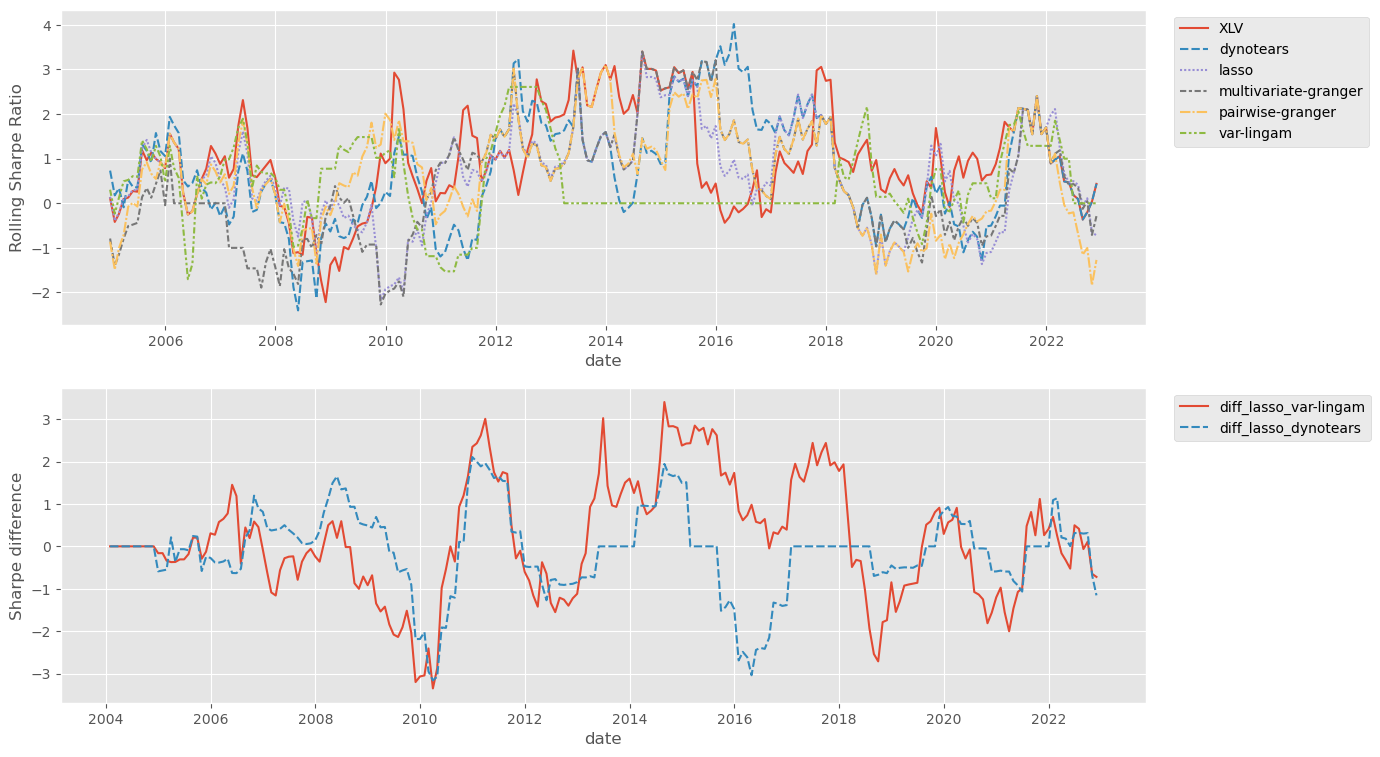

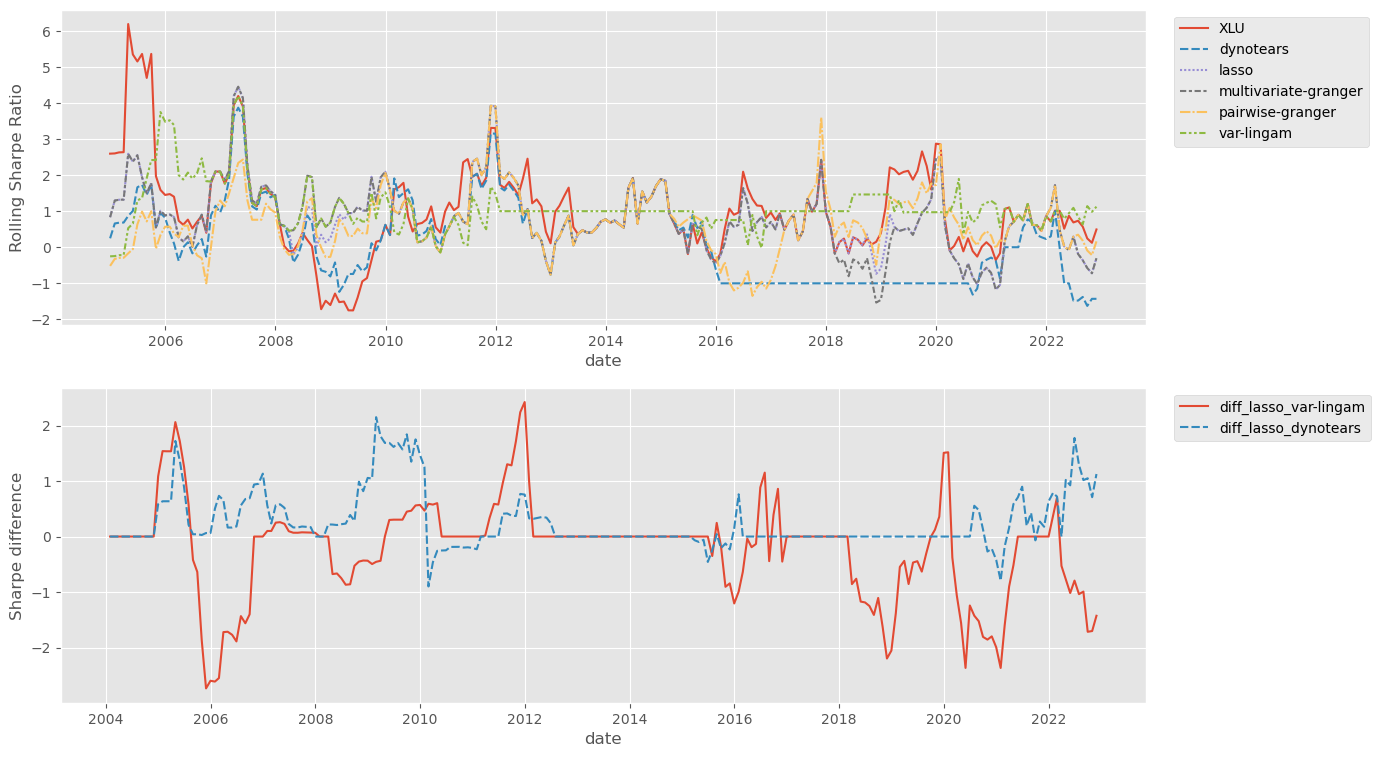

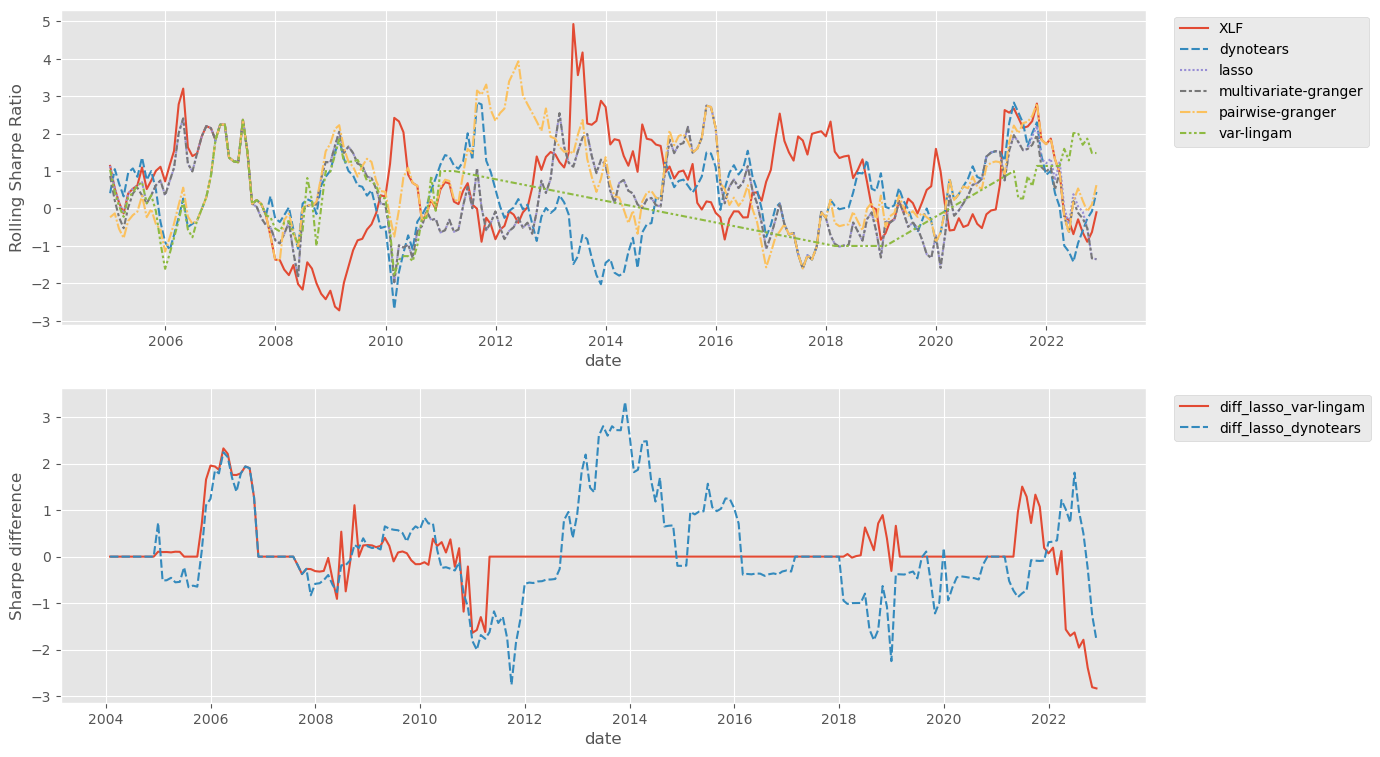

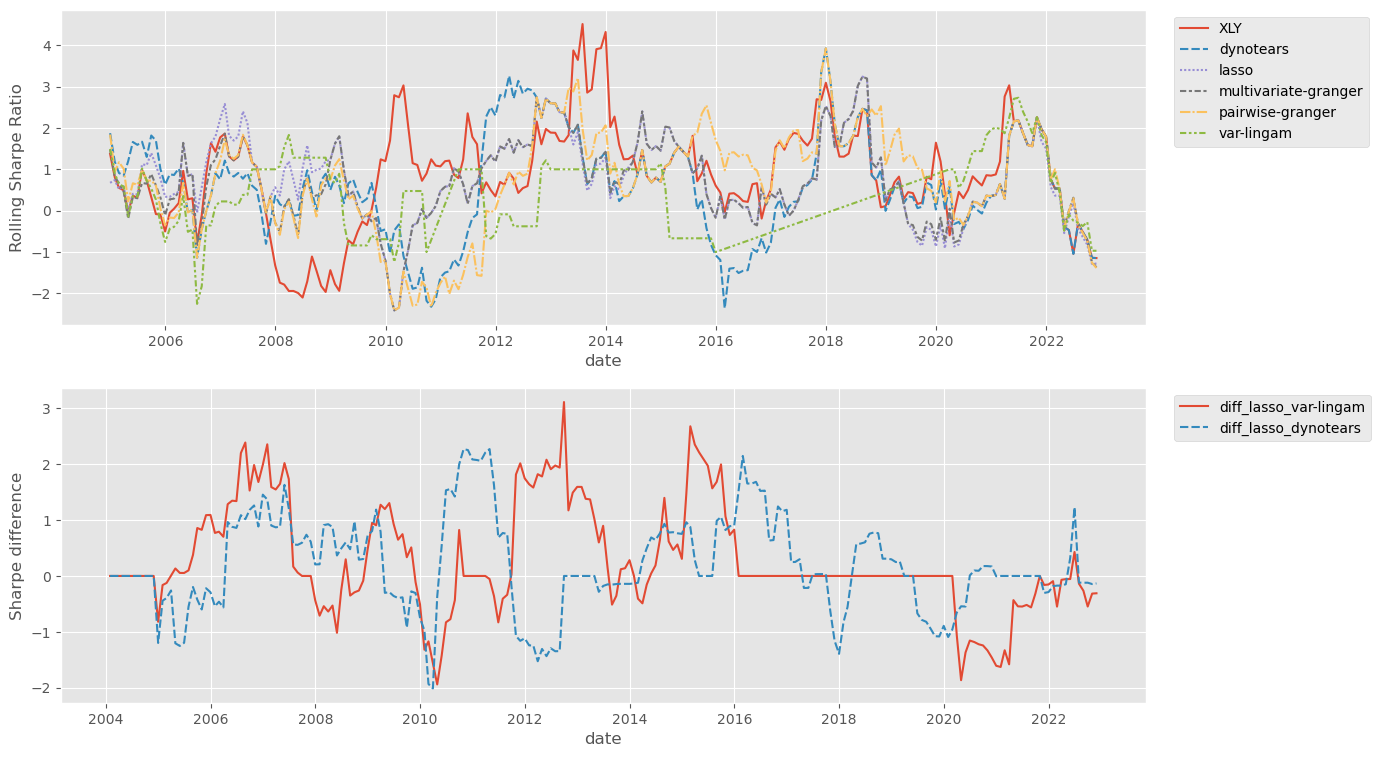

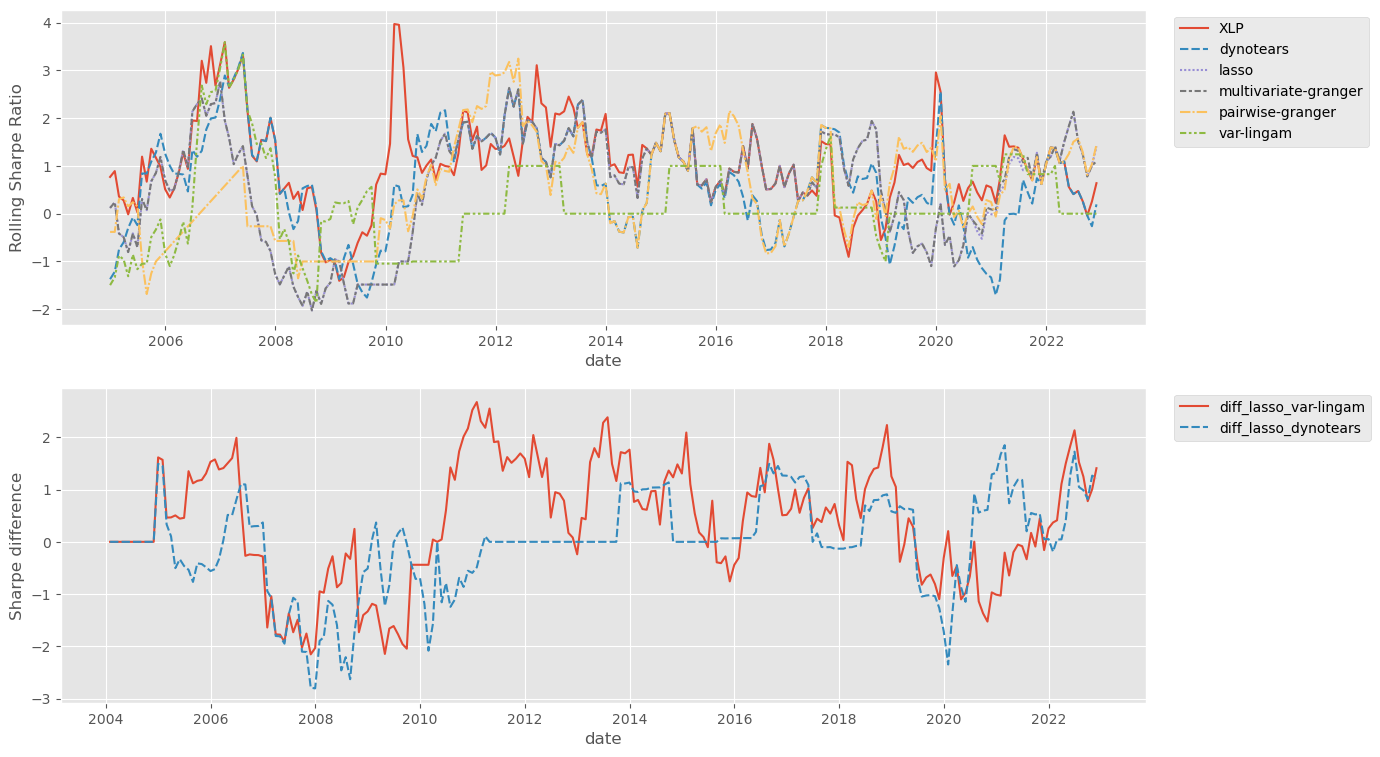

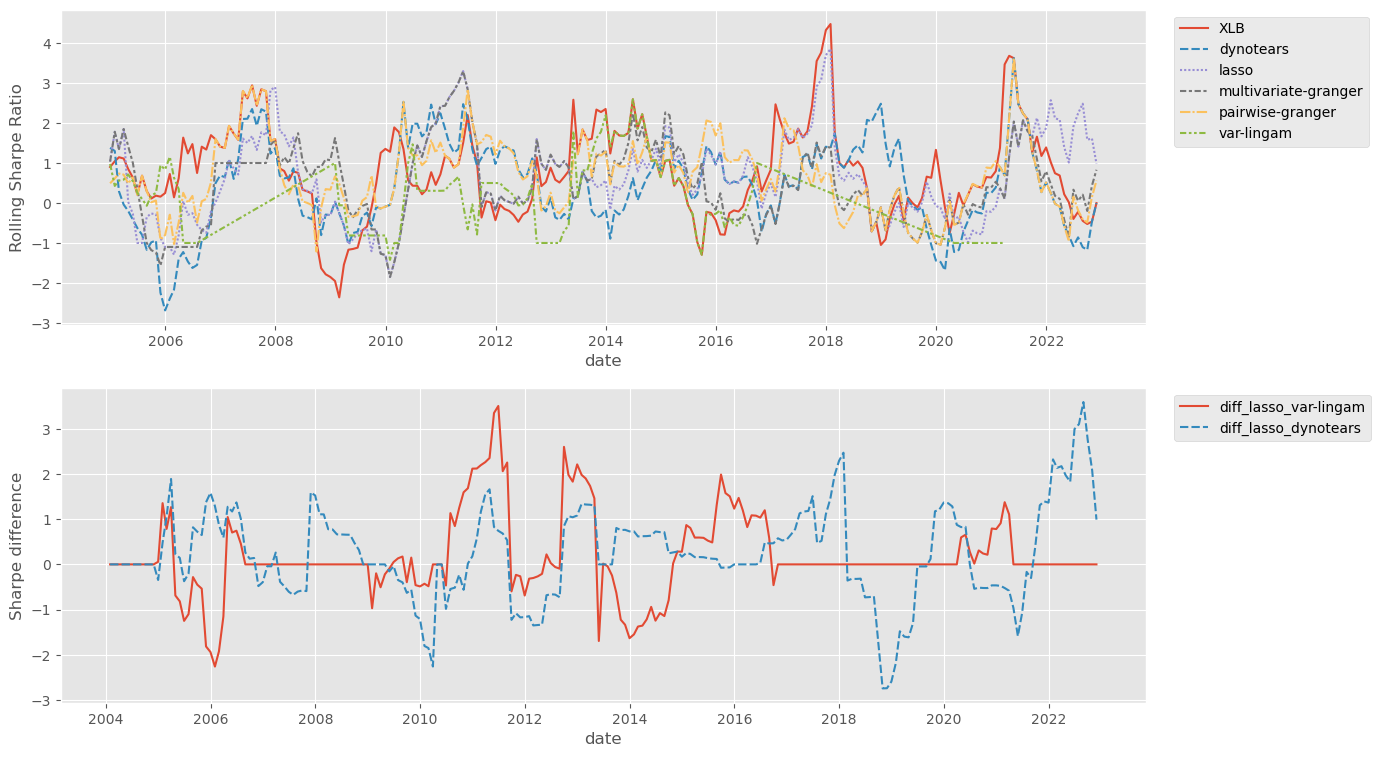

In [20]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    rolling_sharpe_df = tmp_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)
    rolling_sharpe_diff_df = pd.DataFrame(rolling_sharpe_df["lasso"] - rolling_sharpe_df["var-lingam"], columns=["diff_lasso_var-lingam"])
    rolling_sharpe_diff_df["diff_lasso_dynotears"] = rolling_sharpe_df["lasso"] - rolling_sharpe_df["dynotears"]
    rolling_sharpe_diff_df = rolling_sharpe_diff_df.fillna(0)

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = rolling_sharpe_df, ax = ax[0])
    ax[0].set_ylabel("Rolling Sharpe Ratio")
    sns.lineplot(data = rolling_sharpe_diff_df, ax = ax[1])
    ax[1].set_ylabel("Sharpe difference")

    # set position of legend
    ax[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # export figure
    fig.savefig(f"{target}_rolling_sharpe_fs.png")

### Plot Cumulative Returns and Rolling Sharpe Ratios for Combined Portfolio

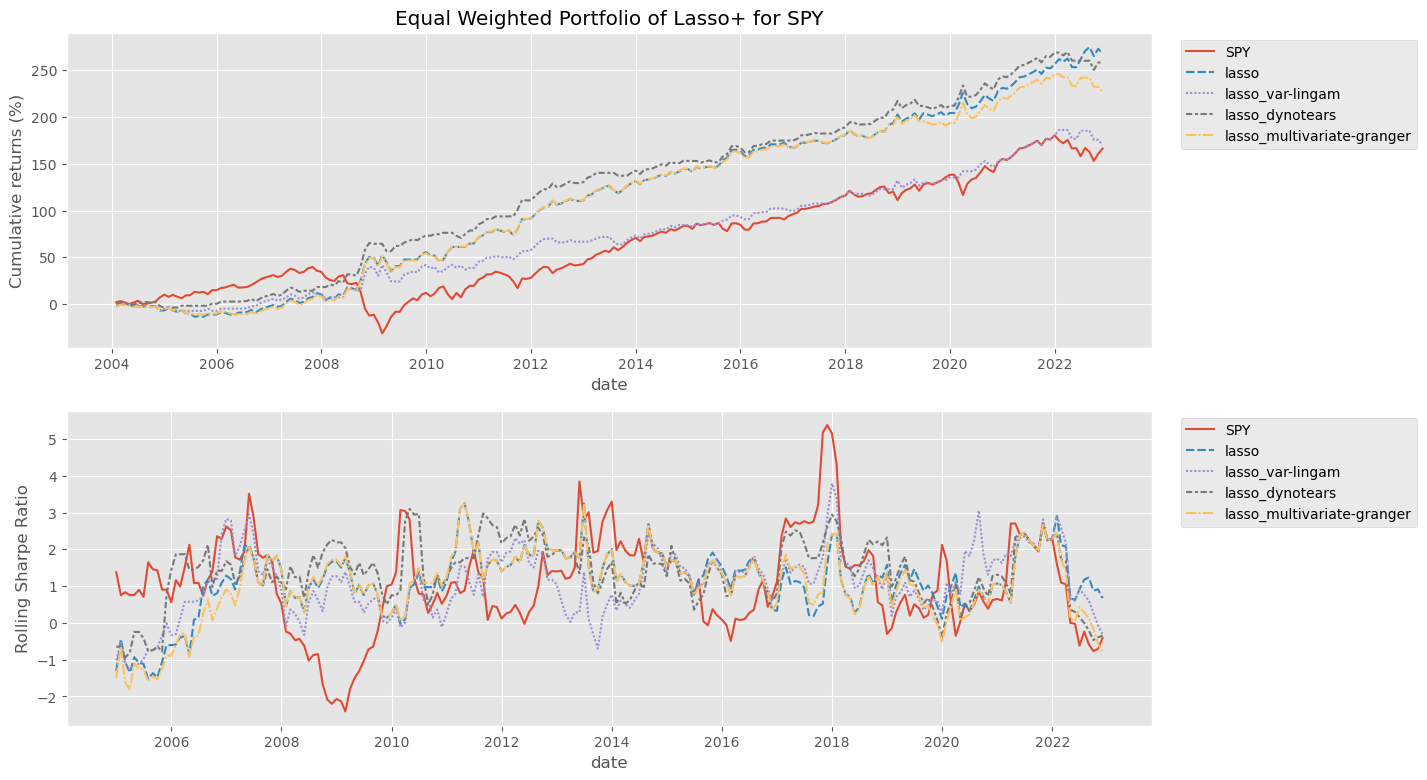

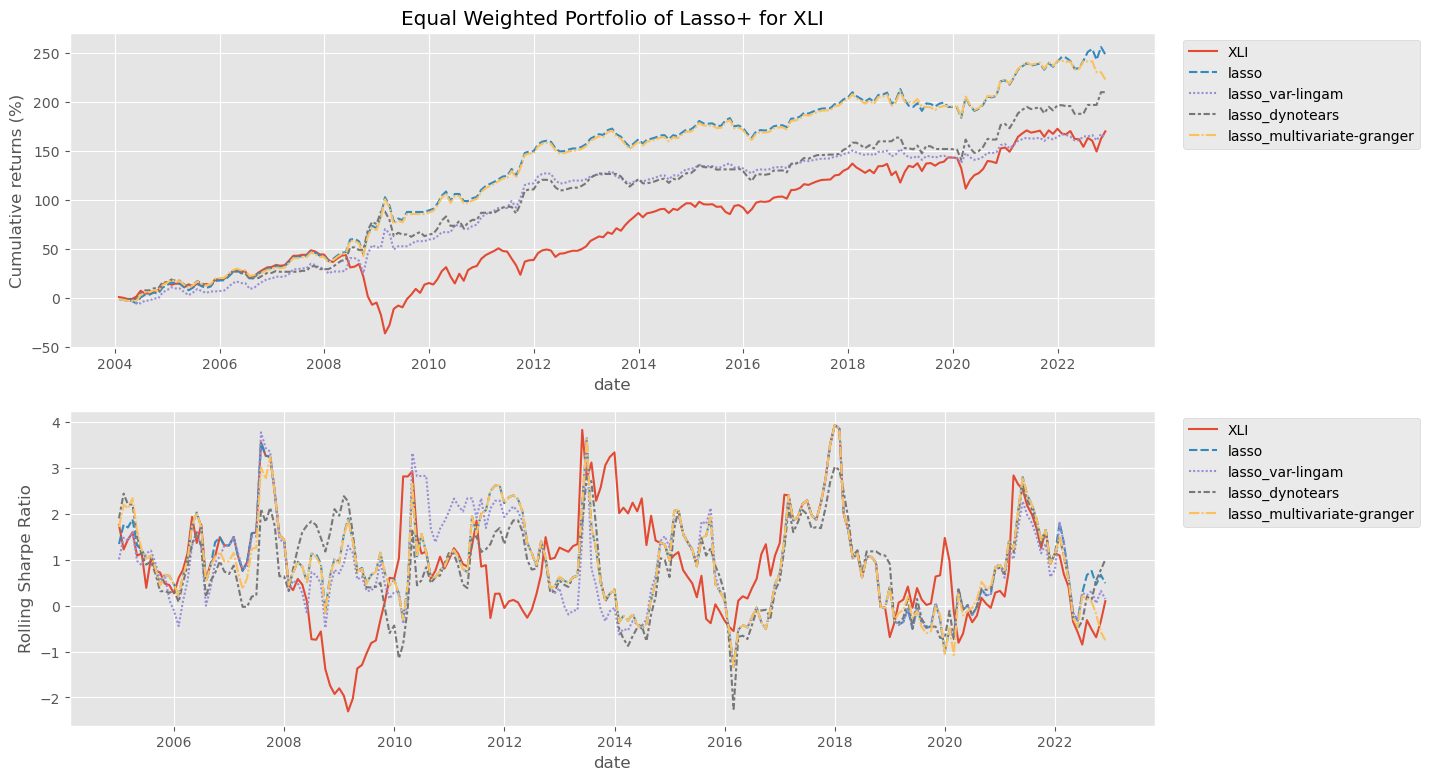

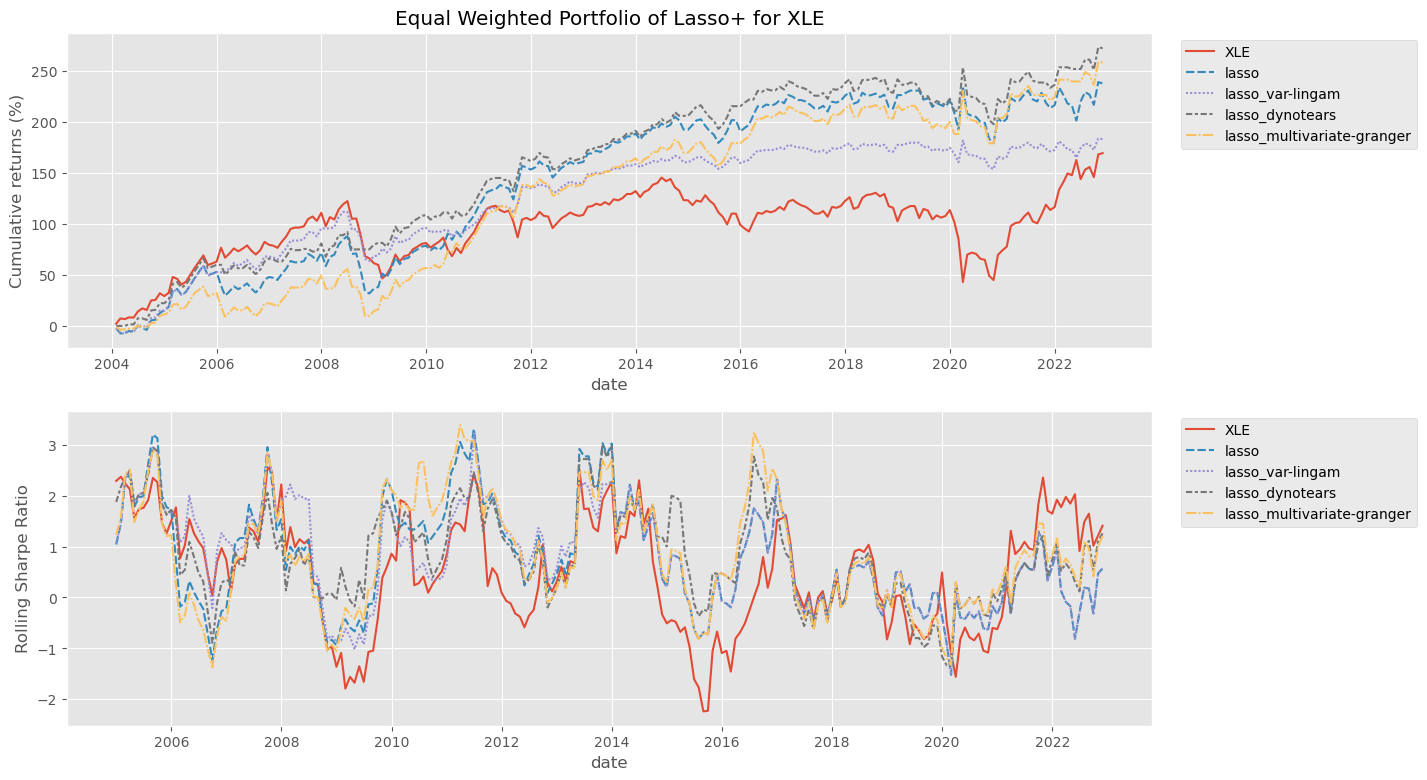

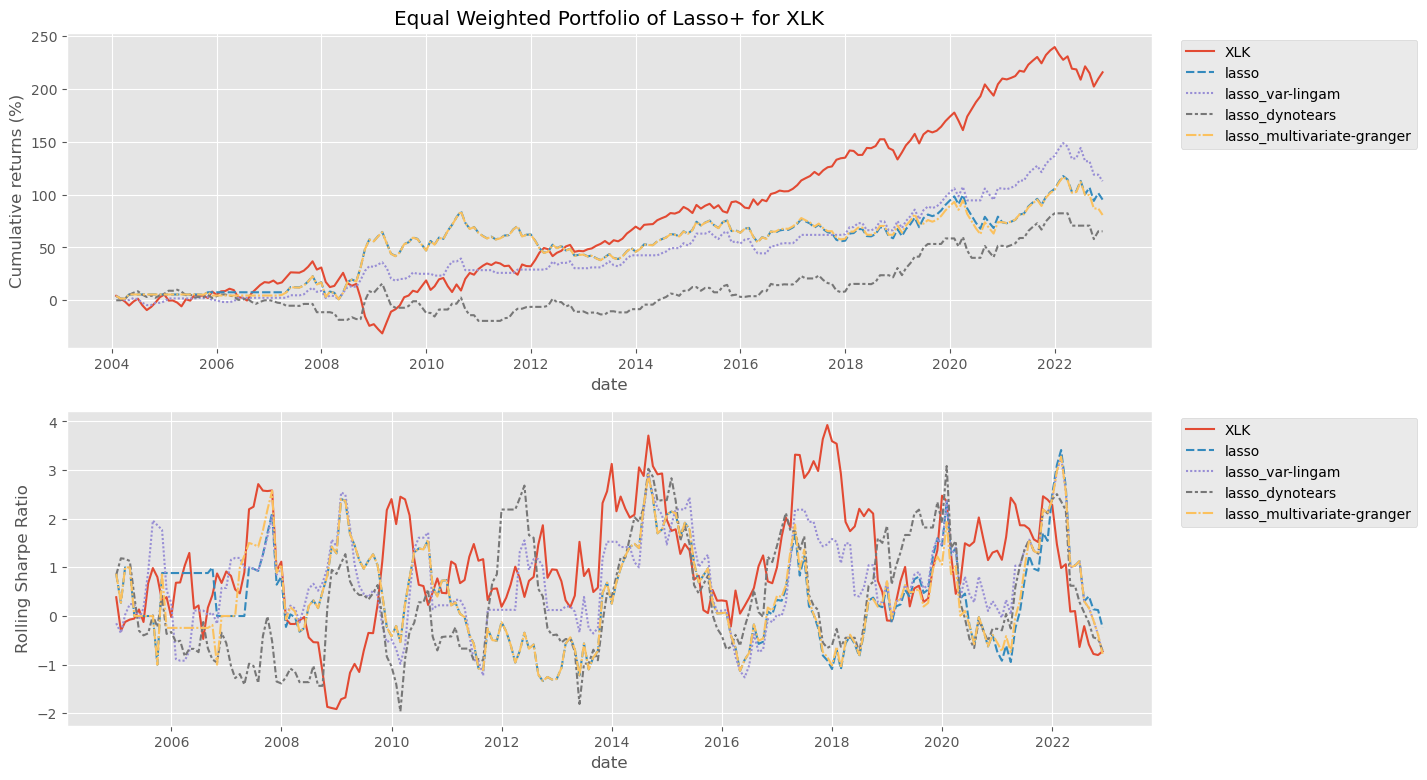

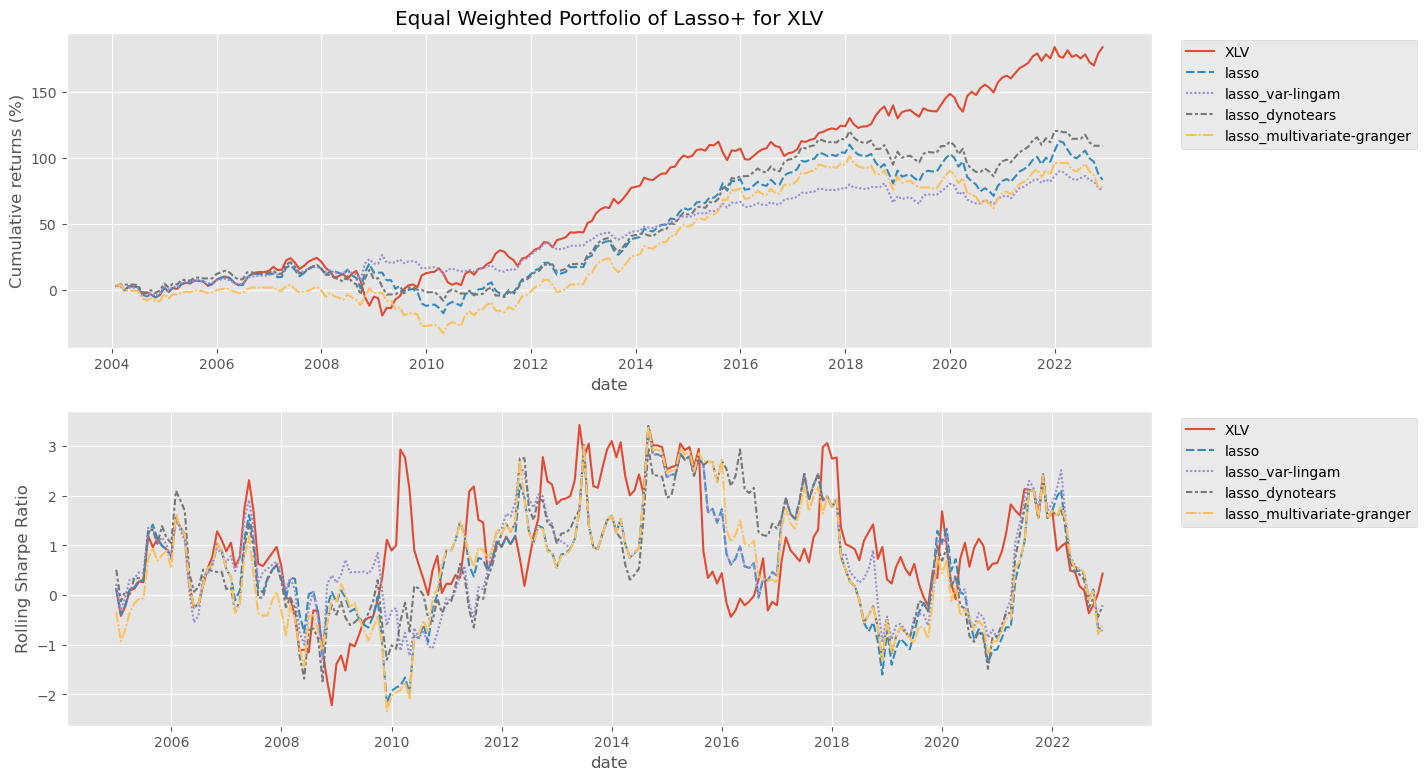

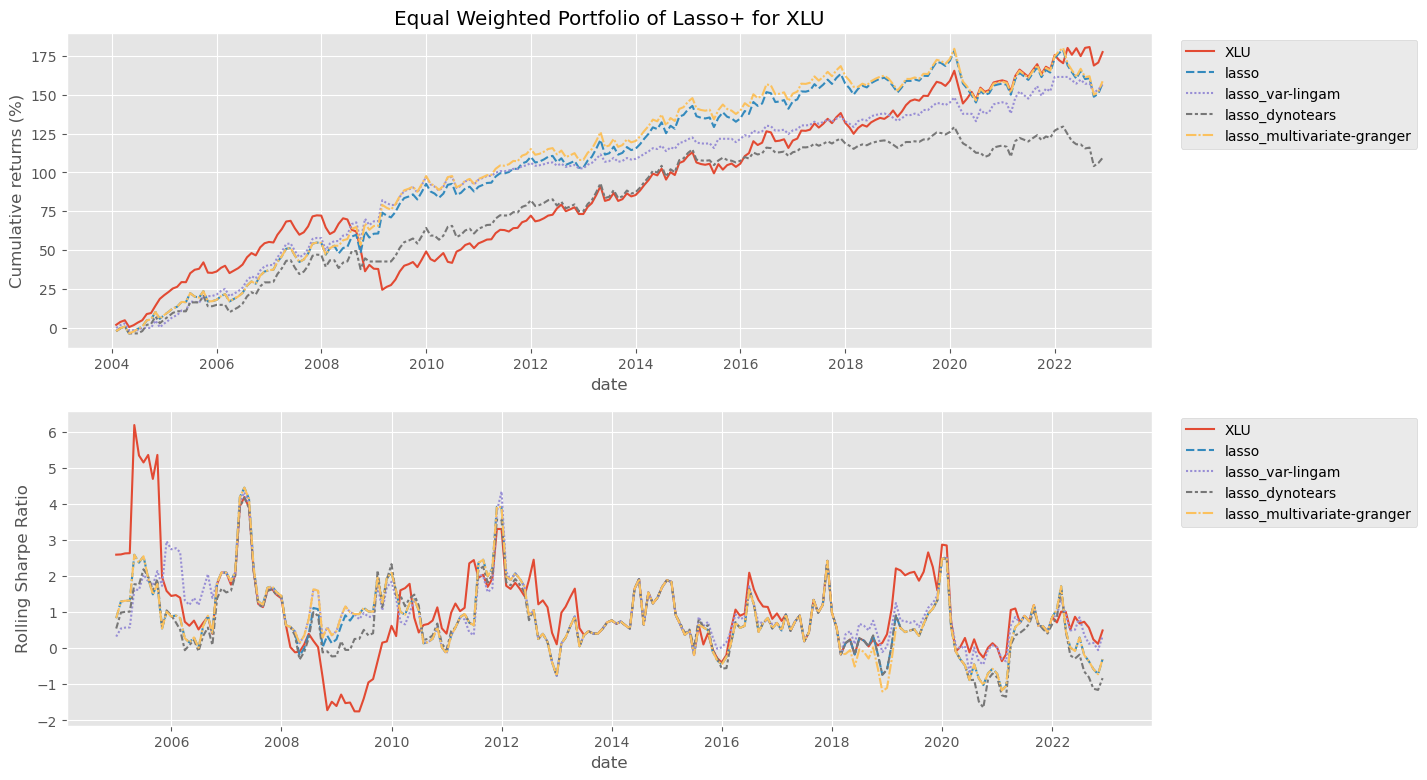

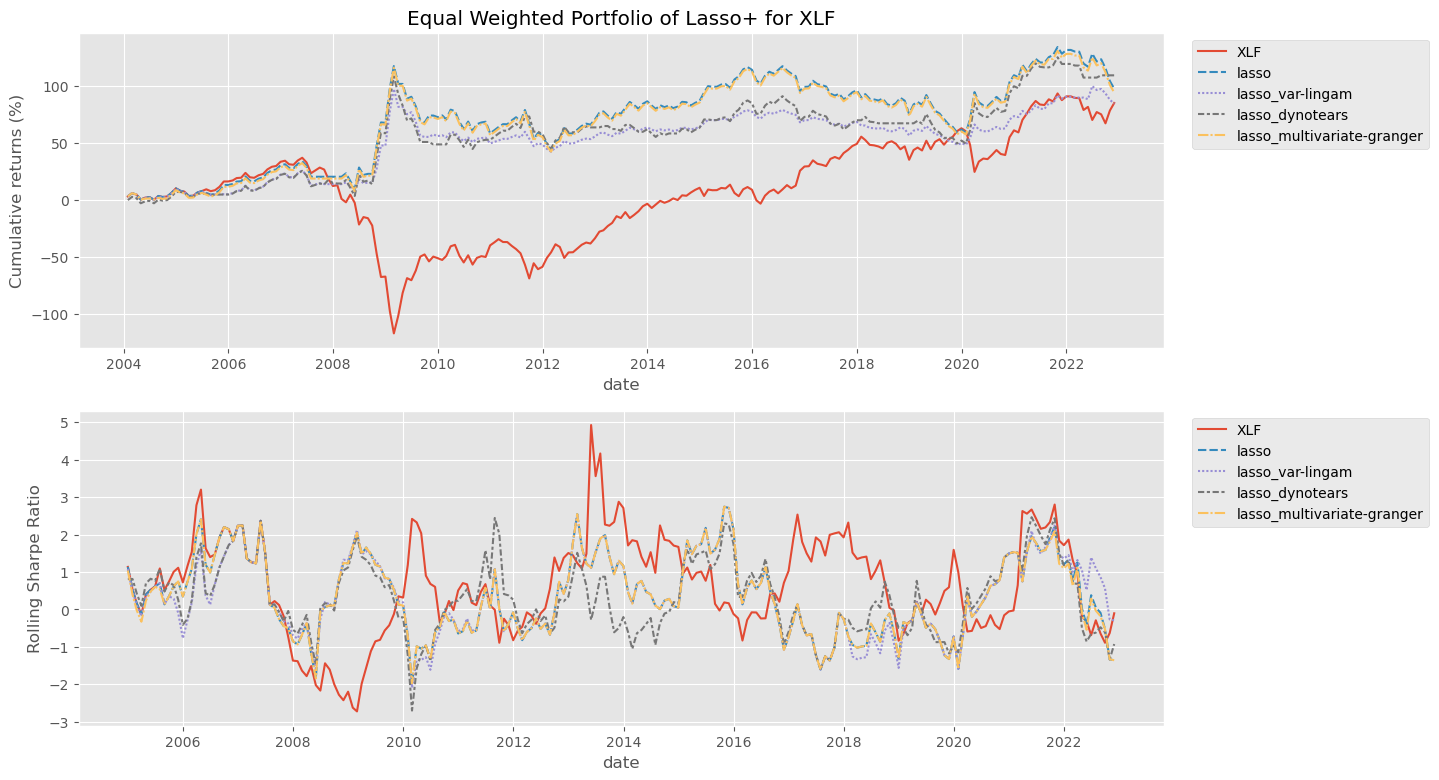

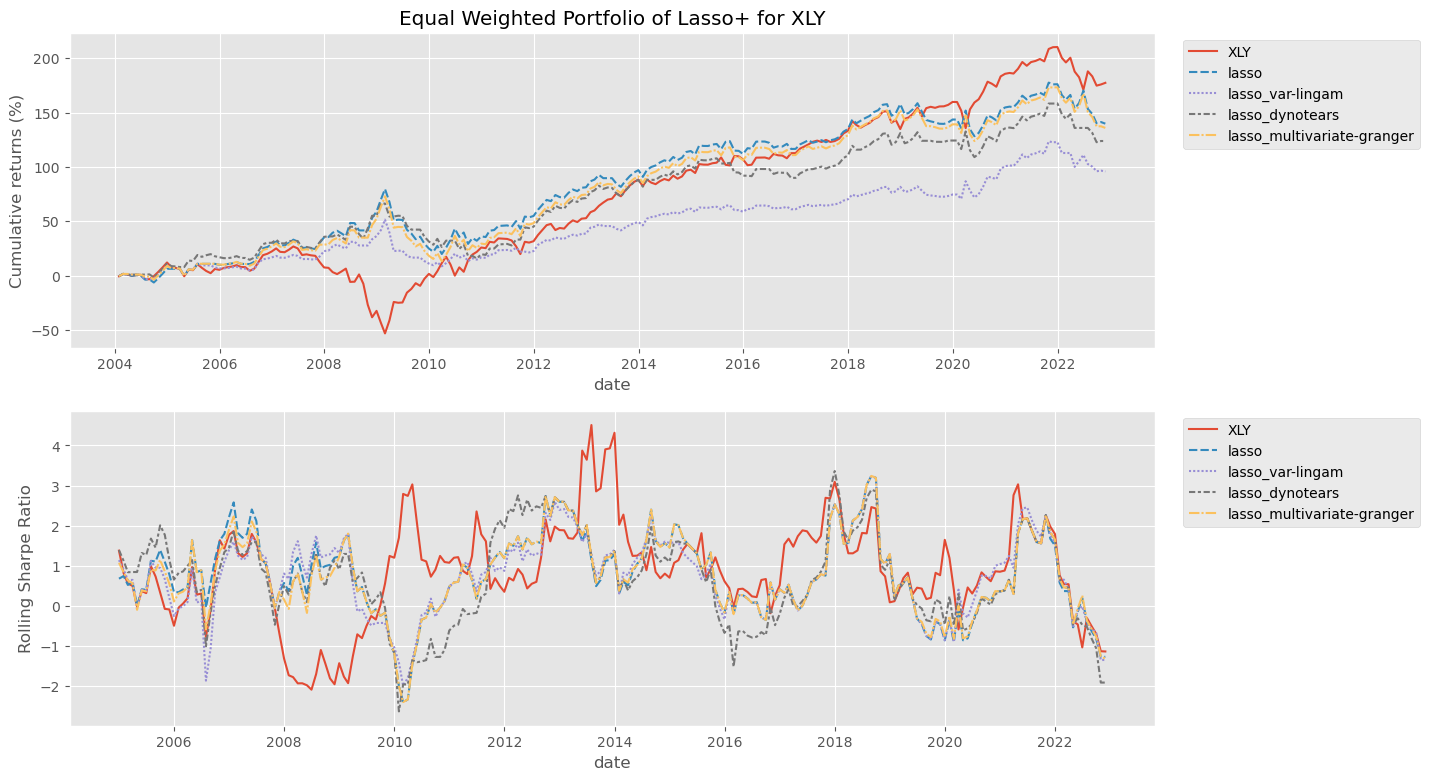

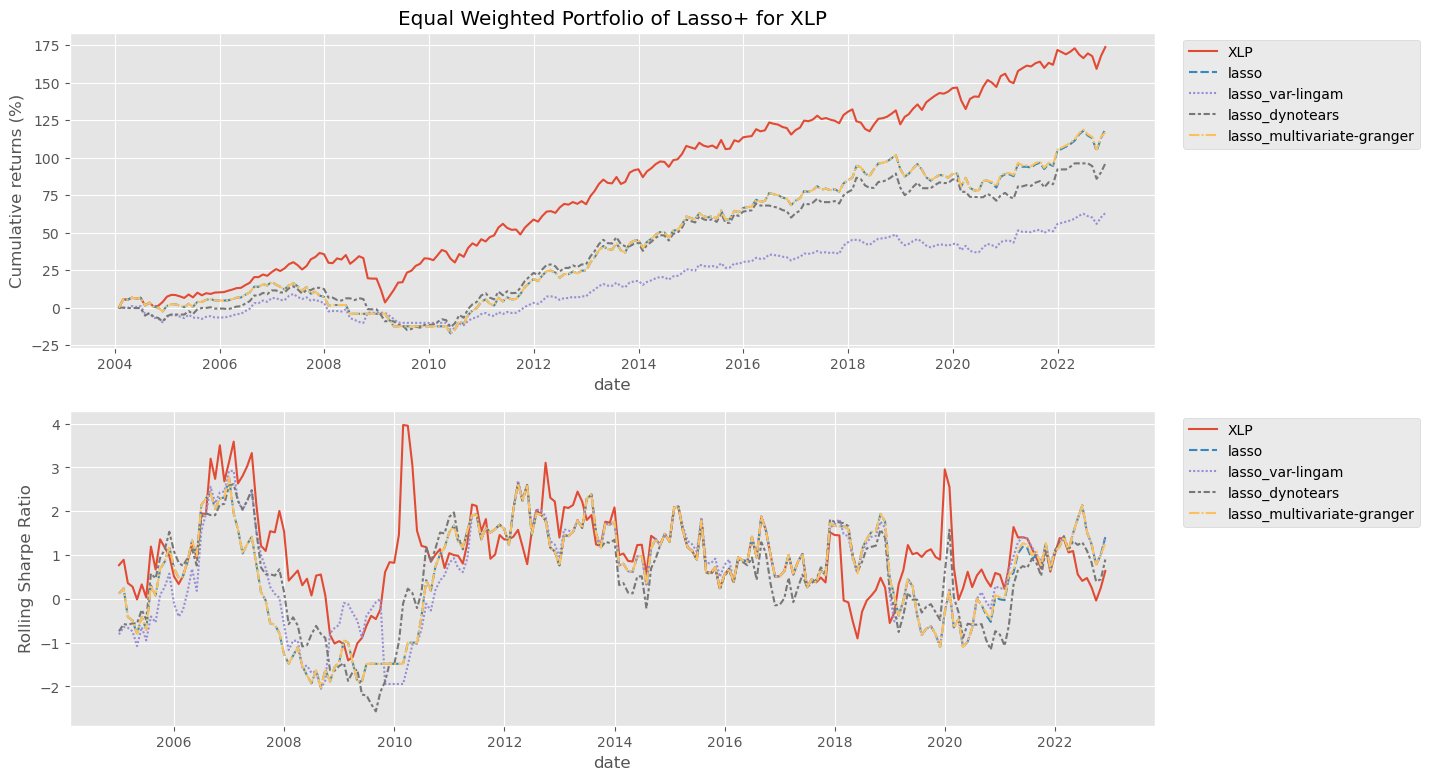

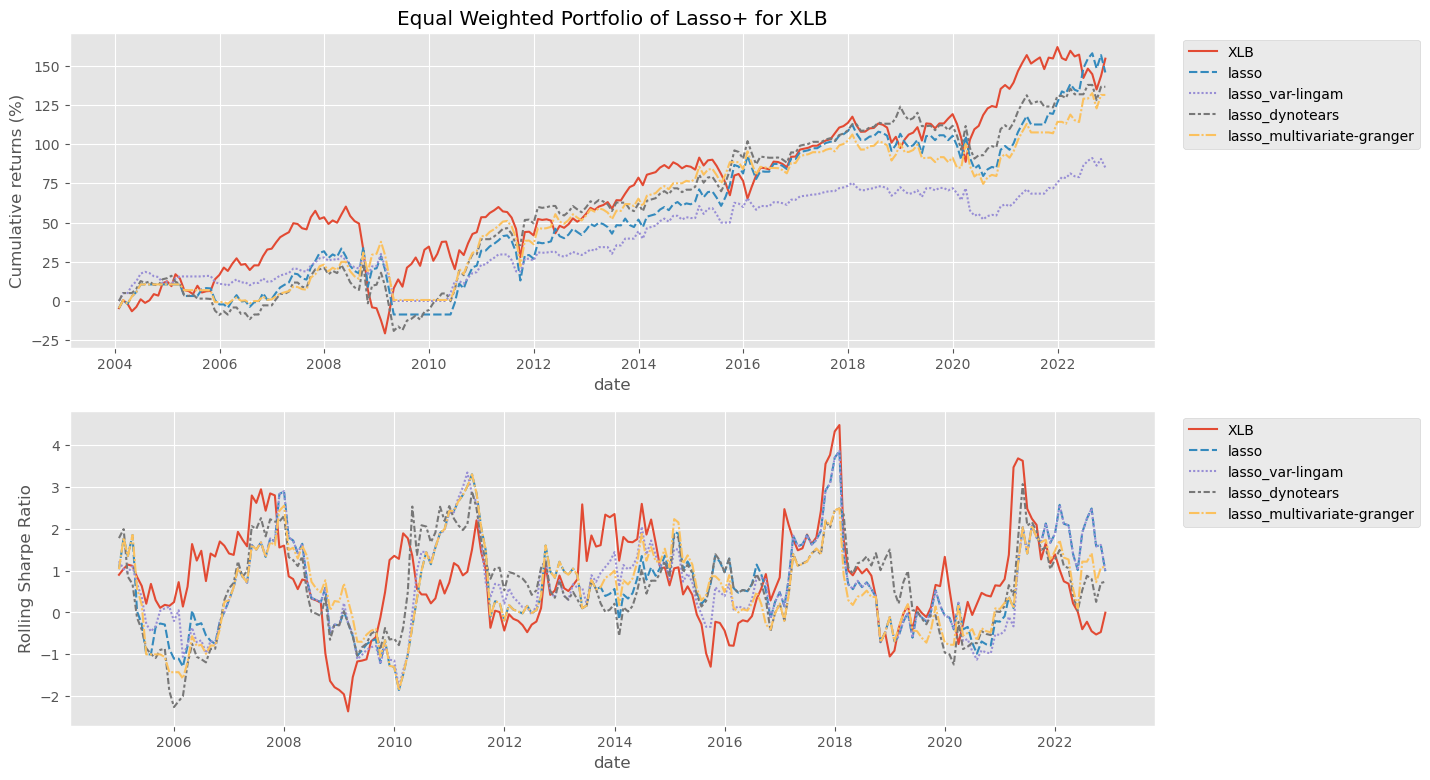

In [21]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["var-lingam"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["dynotears"]
    tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "lasso", "lasso_var-lingam", "lasso_dynotears", "lasso_multivariate-granger"]].copy()

    new_rolling_sharpe_df = new_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)    

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = new_dfPnl.cumsum() * 100, ax = ax[0])
    ax[0].set_ylabel("Cumulative returns (%)")
    ax[0].set_title(f"Equal Weighted Portfolio of Lasso+ for {target}")

    sns.lineplot(data = new_rolling_sharpe_df, ax = ax[1])
    ax[1].set_ylabel("Rolling Sharpe Ratio")

    ax[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # export figure
    fig.savefig(f"{target}_cum_ret_combined.png")

In [11]:
all_measures = []
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["var-lingam"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["dynotears"]
    tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "lasso", "lasso_var-lingam", "lasso_dynotears", "lasso_multivariate-granger"]].copy()

    i = 0
    for tag, measure in metric_funcs.items():
        measure_values = measure(new_dfPnl)

        if i == 0:
            tmp_measure = pd.DataFrame(measure_values, columns=[tag])
        else:
            tmp_measure[tag] = measure_values
        i += 1
    
    tmp_measure["etf"] = target
    tmp_measure = tmp_measure.reset_index().set_index(["etf", "variable"])

    all_measures.append(tmp_measure)

all_measures_df = pd.concat(all_measures, axis=0)
melt_all_measures_df = all_measures_df.reset_index().rename(columns={"variable": "fs"}).melt(id_vars=["etf", "fs"])

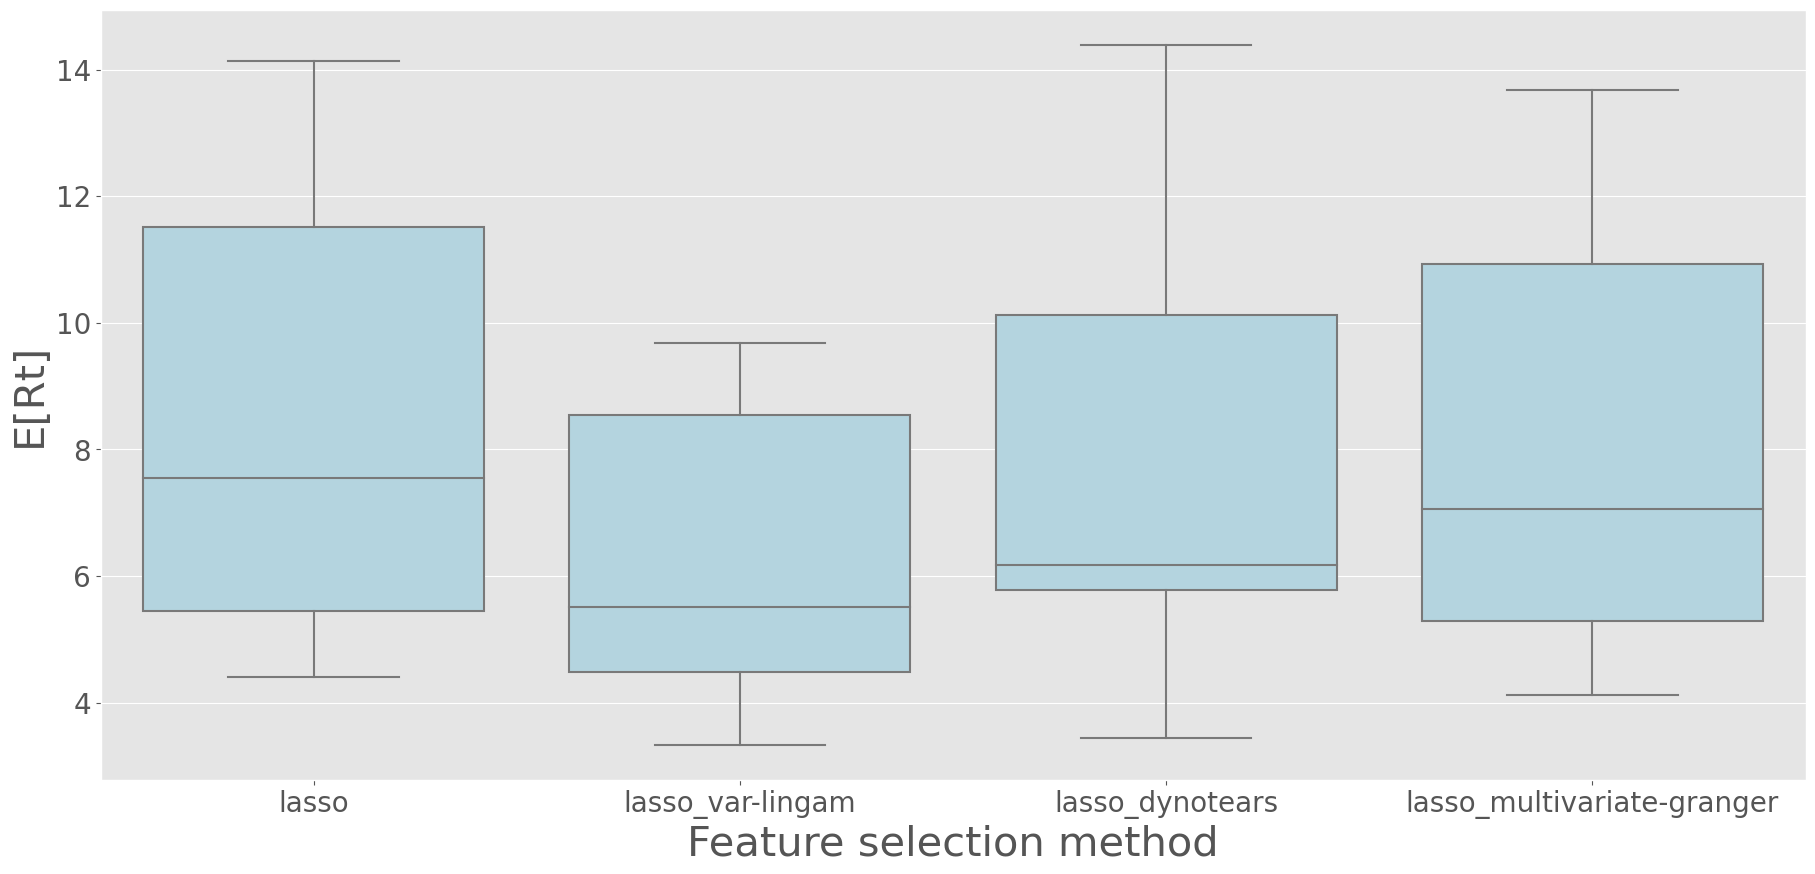

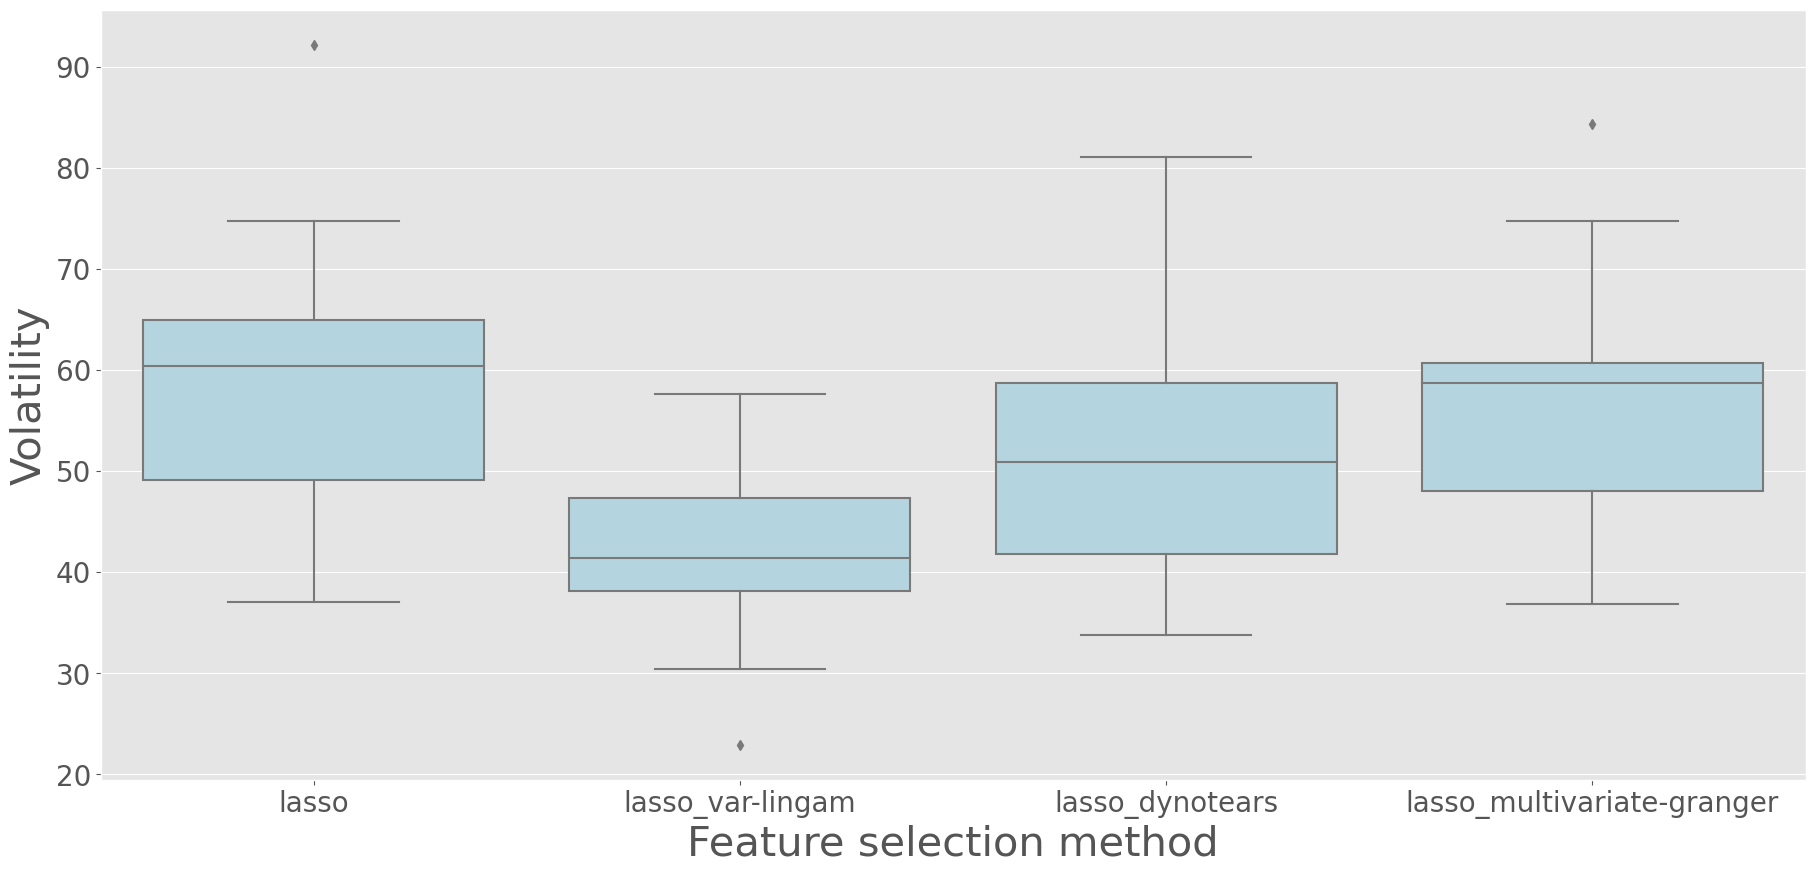

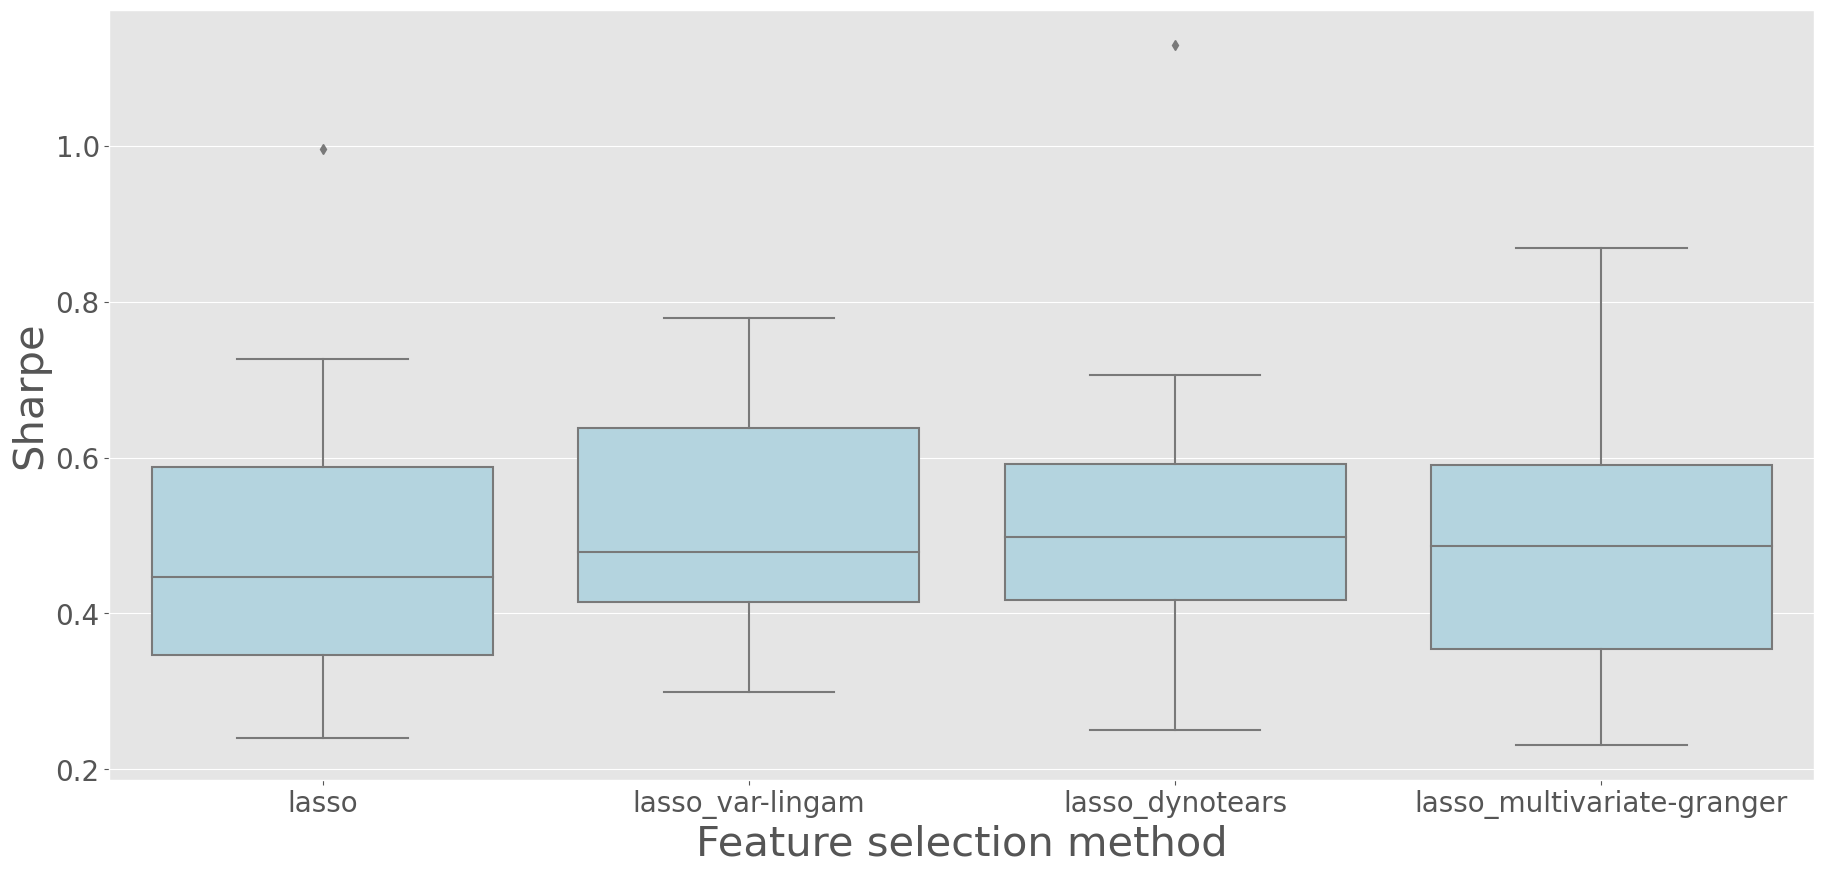

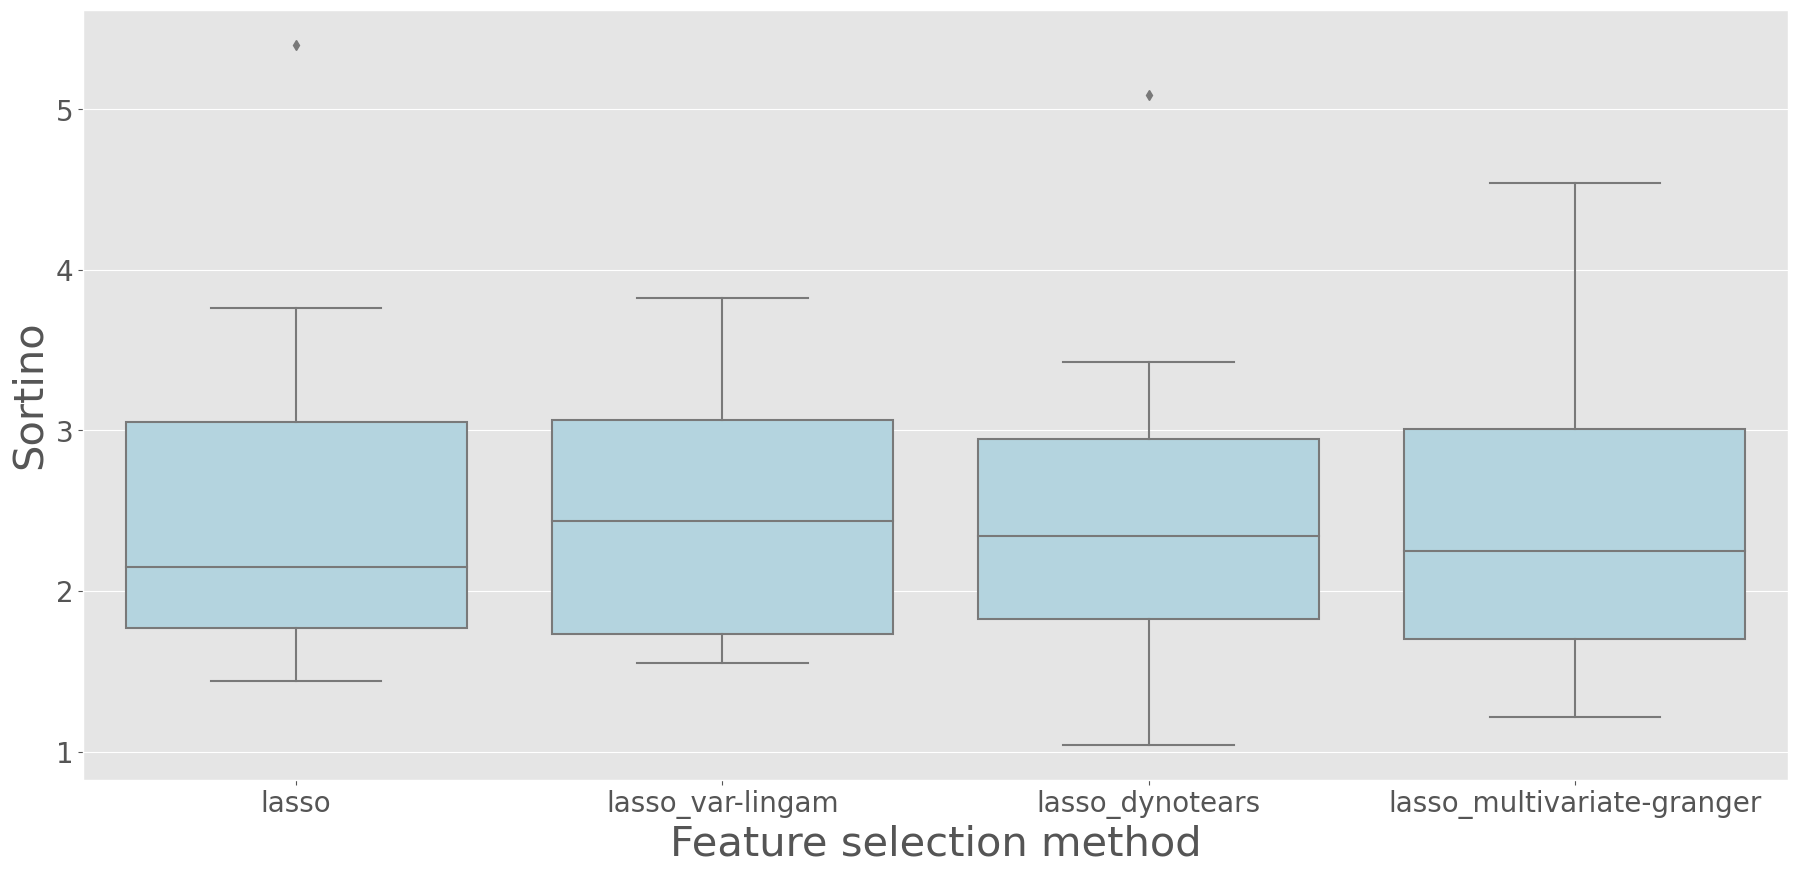

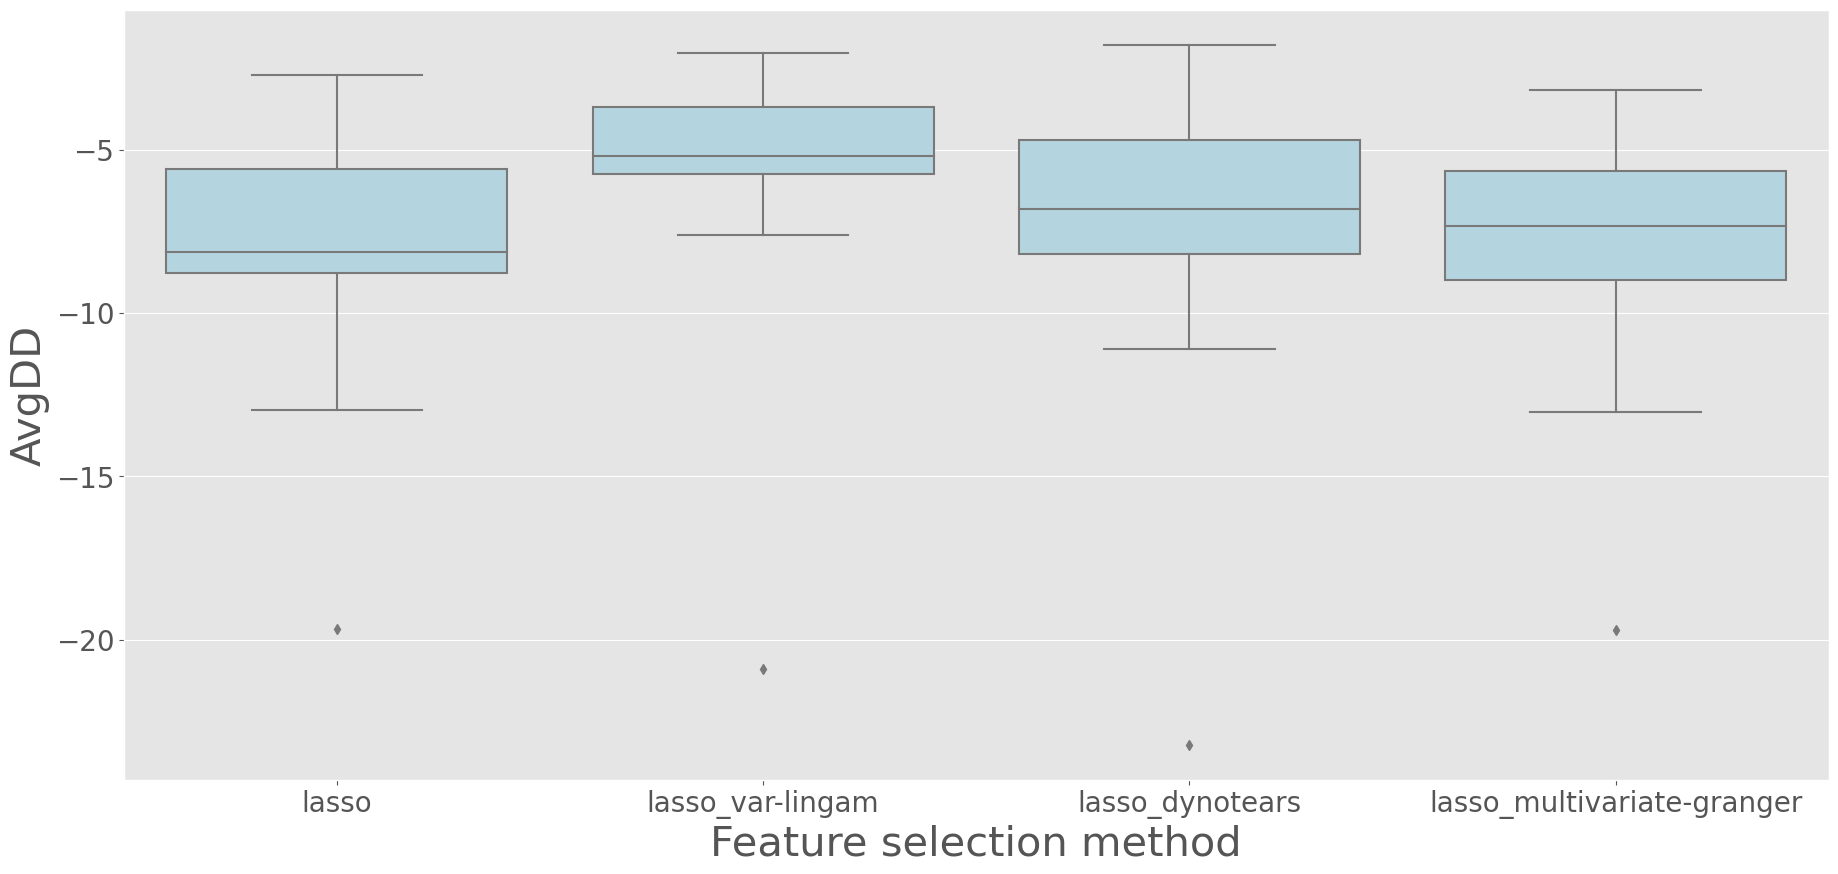

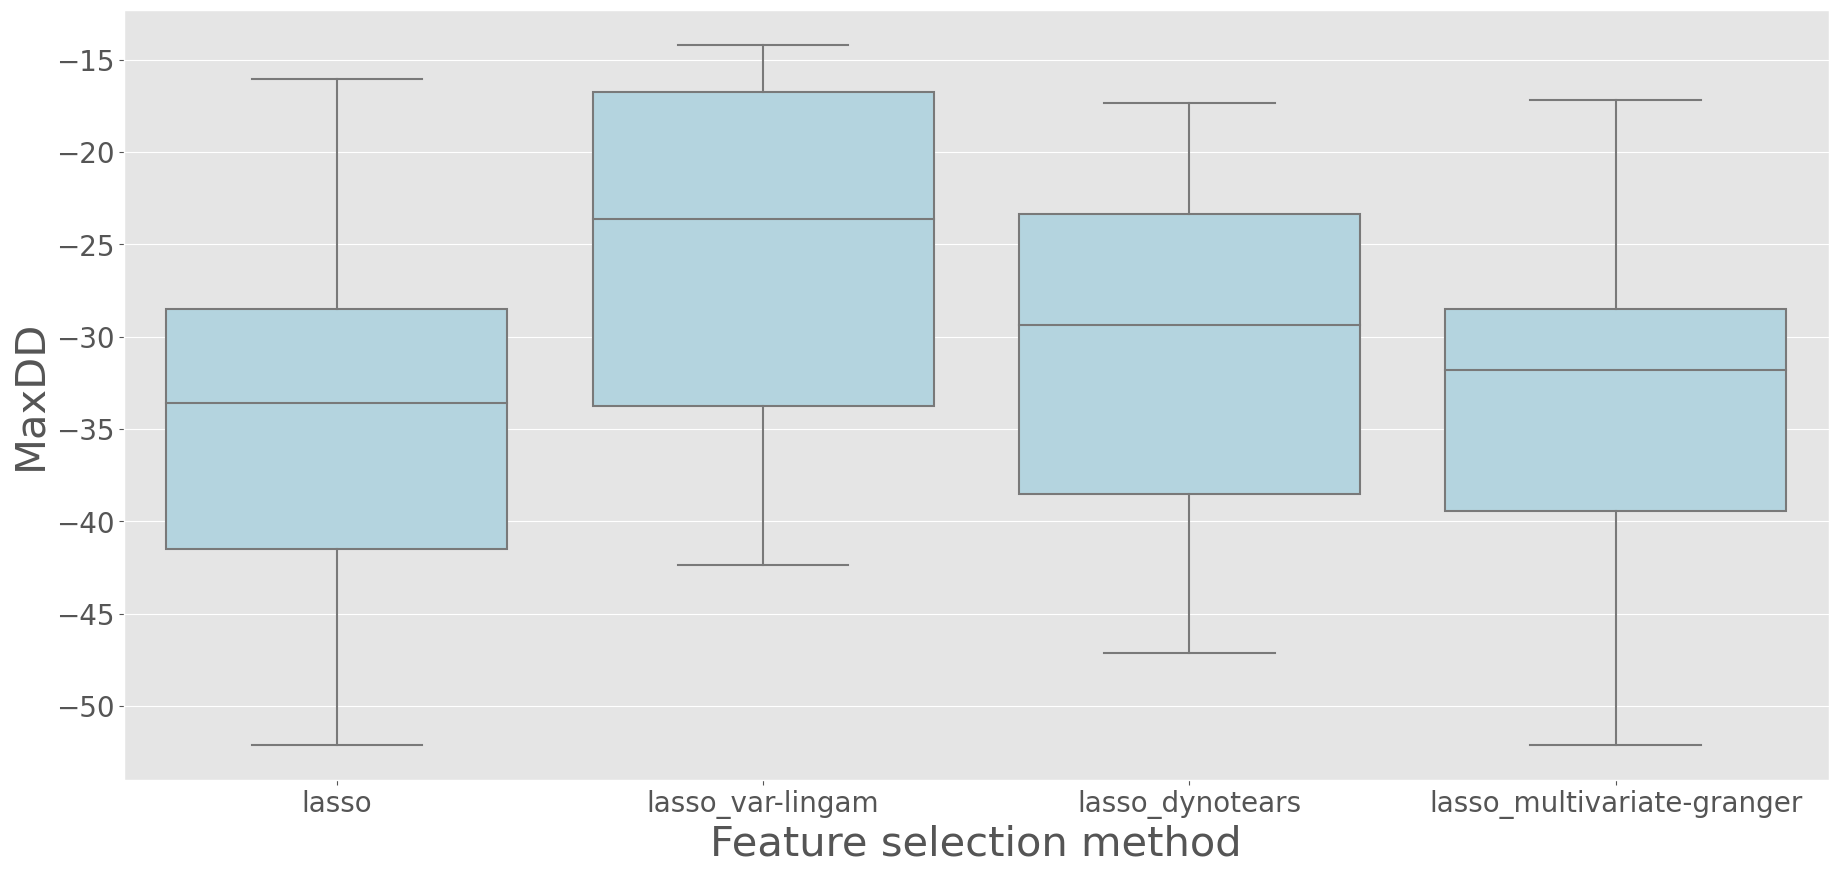

In [12]:
for measure in melt_all_measures_df["variable"].unique():
    boxplot_df = melt_all_measures_df.loc[(melt_all_measures_df["variable"] == measure)&
                                          (~melt_all_measures_df["fs"].isin(etfs_large))].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(measure, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)

In [13]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"])

E[Rt]  Volatility    Sharpe   Sortino  \
etf variable                                                                
SPY lasso_dynotears             13.642014   41.819527  1.130030  5.091398   
    lasso                       14.130455   49.158083  0.995754  5.401781   
XLB lasso_dynotears              7.220031   60.197626  0.415480  1.819631   
    lasso_multivariate-granger   6.944566   58.501847  0.411212  1.805858   
XLE lasso_dynotears             14.391690   81.082852  0.614856  3.102533   
    lasso_var-lingam             9.685082   57.631283  0.582151  2.759096   
XLF lasso_var-lingam             4.480441   51.804288  0.299603  1.795516   
    lasso_dynotears              5.793632   68.693620  0.292163  1.639613   
XLI lasso                       13.128719   62.540251  0.727199  3.764307   
    lasso_dynotears             11.094948   54.397227  0.706544  3.428187   
XLK XLK                         11.404709   61.696761  0.640343  3.150071   
    lasso_var-lingam             5.958420   47.944672  0.430508  1.595318   
XLP XLP                          9.189215   40.717687  0.781783  3.622312   
    lasso                        6.293611   37.039851  0.588601  3.079389   
XLU lasso_var-lingam             8.277430   37.572959  0.763151  3.825726   
    XLU                          9.376970   49.031892  0.662483  2.848071   
XLV XLV                          9.732134   47.427419  0.710836  3.551596   
    lasso_dynotears              5.776961   41.727884  0.479583  2.461406   
XLY XLY                          9.379336   63.358850  0.512809  2.366445   
    lasso                        7.393378   60.901975  0.420535  1.843251   

                                    AvgDD      MaxDD  
etf variable                                          
SPY lasso_dynotears             -1.794332 -17.366784  
    lasso                       -2.723596 -16.024124  
XLB lasso_dynotears             -7.552104 -34.907527  
    lasso_multivariate-granger  -7.185692 -31.002969  
XLE lasso_dynotears             -6.095504 -42.689333  
    lasso_var-lingam            -5.860243 -38.184216  
XLF lasso_var-lingam           -20.892781 -42.385848  
    lasso_dynotears            -23.203452 -47.137354  
XLI lasso                       -5.115624 -25.288780  
    lasso_dynotears             -4.439362 -22.720776  
XLK XLK                         -6.874789 -49.449976  
    lasso_var-lingam            -5.232416 -30.255839  
XLP XLP                         -2.897640 -28.129897  
    lasso                       -7.061384 -29.155716  
XLU lasso_var-lingam            -2.053237 -14.190232  
    XLU                         -6.594952 -38.031411  
XLV XLV                         -5.053252 -35.494707  
    lasso_dynotears             -7.971101 -29.056776  
XLY XLY                         -7.253564 -55.071088  
    lasso                       -8.823482 -45.006149

In [17]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &       &      E[Rt] &  Volatility &    Sharpe &   Sortino &      AvgDD &      MaxDD \\
etf & variable &            &             &           &           &            &            \\
\midrule
SPY & lasso\_dynotears &  13.642014 &   41.819527 &  1.130030 &  5.091398 &  -1.794332 & -17.366784 \\
    & lasso &  14.130455 &   49.158083 &  0.995754 &  5.401781 &  -2.723596 & -16.024124 \\
XLB & lasso\_dynotears &   7.220031 &   60.197626 &  0.415480 &  1.819631 &  -7.552104 & -34.907527 \\
    & lasso\_multivariate-granger &   6.944566 &   58.501847 &  0.411212 &  1.805858 &  -7.185692 & -31.002969 \\
XLE & lasso\_dynotears &  14.391690 &   81.082852 &  0.614856 &  3.102533 &  -6.095504 & -42.689333 \\
    & lasso\_var-lingam &   9.685082 &   57.631283 &  0.582151 &  2.759096 &  -5.860243 & -38.184216 \\
XLF & lasso\_var-lingam &   4.480441 &   51.804288 &  0.299603 &  1.795516 & -20.892781 & -42.385848 \\
    & lasso\_dynotears &   5.793632 &   68.693

In [14]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).set_index(["etf", "variable"])

E[Rt]  Volatility    Sharpe   Sortino  \
etf variable                                                                
SPY lasso                       14.130455   49.158083  0.995754  5.401781   
    lasso_var-lingam             8.992953   39.955912  0.779672  3.476135   
XLB lasso_var-lingam             4.495698   39.910198  0.390215  1.550503   
    lasso_multivariate-granger   6.944566   58.501847  0.411212  1.805858   
XLE lasso_var-lingam             9.685082   57.631283  0.582151  2.759096   
    lasso_multivariate-granger  13.675822   84.351367  0.561632  2.689143   
XLF lasso_var-lingam             4.480441   51.804288  0.299603  1.795516   
    lasso_dynotears              5.793632   68.693620  0.292163  1.639613   
XLI lasso_var-lingam             8.639472   45.608513  0.656193  3.169875   
    lasso_dynotears             11.094948   54.397227  0.706544  3.428187   
XLK lasso_dynotears              3.450448   47.753853  0.250298  1.042502   
    lasso_var-lingam             5.958420   47.944672  0.430508  1.595318   
XLP lasso_var-lingam             3.337824   22.926824  0.504325  2.575118   
    lasso_dynotears              5.084352   33.793288  0.521190  2.481595   
XLU lasso_var-lingam             8.277430   37.572959  0.763151  3.825726   
    lasso_dynotears              5.781318   38.669666  0.517901  2.228994   
XLV lasso_var-lingam             3.973043   30.412719  0.452542  2.291757   
    lasso_dynotears              5.776961   41.727884  0.479583  2.461406   
XLY lasso_var-lingam             5.069232   42.861202  0.409702  1.708060   
    lasso_dynotears              6.549177   53.993597  0.420180  1.833728   

                                    AvgDD      MaxDD  
etf variable                                          
SPY lasso                       -2.723596 -16.024124  
    lasso_var-lingam            -2.517053 -16.080220  
XLB lasso_var-lingam            -5.395747 -25.901043  
    lasso_multivariate-granger  -7.185692 -31.002969  
XLE lasso_var-lingam            -5.860243 -38.184216  
    lasso_multivariate-granger  -7.488653 -40.234899  
XLF lasso_var-lingam           -20.892781 -42.385848  
    lasso_dynotears            -23.203452 -47.137354  
XLI lasso_var-lingam            -3.612656 -18.795851  
    lasso_dynotears             -4.439362 -22.720776  
XLK lasso_dynotears            -11.103410 -29.708098  
    lasso_var-lingam            -5.232416 -30.255839  
XLP lasso_var-lingam            -5.136068 -21.385858  
    lasso_dynotears             -5.539849 -25.288449  
XLU lasso_var-lingam            -2.053237 -14.190232  
    lasso_dynotears             -3.989612 -22.441099  
XLV lasso_var-lingam            -3.984349 -14.598825  
    lasso_dynotears             -7.971101 -29.056776  
XLY lasso_var-lingam            -7.619034 -34.918596  
    lasso_dynotears             -8.278341 -39.734406

In [18]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).set_index(["etf", "variable"]).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &                 &      E[Rt] &  Volatility &    Sharpe &   Sortino &      AvgDD &      MaxDD \\
etf & variable &            &             &           &           &            &            \\
\midrule
SPY & lasso &  14.130455 &   49.158083 &  0.995754 &  5.401781 &  -2.723596 & -16.024124 \\
    & lasso\_var-lingam &   8.992953 &   39.955912 &  0.779672 &  3.476135 &  -2.517053 & -16.080220 \\
XLB & lasso\_var-lingam &   4.495698 &   39.910198 &  0.390215 &  1.550503 &  -5.395747 & -25.901043 \\
    & lasso\_multivariate-granger &   6.944566 &   58.501847 &  0.411212 &  1.805858 &  -7.185692 & -31.002969 \\
XLE & lasso\_var-lingam &   9.685082 &   57.631283 &  0.582151 &  2.759096 &  -5.860243 & -38.184216 \\
    & lasso\_multivariate-granger &  13.675822 &   84.351367 &  0.561632 &  2.689143 &  -7.488653 & -40.234899 \\
XLF & lasso\_var-lingam &   4.480441 &   51.804288 &  0.299603 &  1.795516 & -20.892781 & -42.385848 \\
    & lasso\_dynotears 

In [15]:
# fig.savefig("PnLPlot.png", bbox_inches = "tight")